# Loading Packages & Initialization

be sure to set:
* nl.model
* model.type
* output_folder
* iteration_budget
* selected_ins

In [2]:
rm(list = ls())

library(data.table)
library(tidyverse)
library(rJava)
library(RNetLogo)

library(lhs)  # For maximin Latin hypercube sampling
library(ggplot2)
library(plotly)  # For beautiful plotting
library(caret)
library(randomForest)
library(factoextra)
library(e1071)
library(TSrepr)  # for evaluating predictive power

require(gridExtra)

options(warn = -1)

In [3]:
Is_Headless <- 1
nl.model <- "Segregation_Dummy"

nl.path <- "C:/Program Files/NetLogo 6.0.4/app"
folder.path = "C:/Users/paslanpatir/Desktop/TEZ_v2/"
model.path <- paste0(folder.path, nl.model, ".nlogo")

if (Is_Headless == 0) {
    NLStart(nl.path, gui = TRUE, nl.jarname = "netlogo-6.0.4.jar")
    NLLoadModel(model.path)
} else {
    NLStart(nl.path, gui = FALSE, nl.jarname = "netlogo-6.0.4.jar", nl.obj = nl.model)
    NLLoadModel(model.path, nl.obj = nl.model)
}

In [4]:
model.type = ifelse(nl.model == "Segregation", "basic", "dummy")
# the path of data folder
data.path = paste0(folder.path,"data/")
# the path for outputs to be record
output.folder = paste0("outputs_Deneme_",Sys.Date())
dir.create(file.path(folder.path, output.folder), showWarnings = FALSE)

outputs.path = paste0(folder.path,output.folder,"/")

In [5]:
# Read Me File to keep info about the output folder
ReadMe = paste0(outputs.path,"ReadMe_",model.type,".txt")

# Model Parameters & Functions

## Set model parameters

In [6]:
## Set model parameters Number of replications for each instance
nofrep = 1

# order feature names according to their definition order in run_model
if (model.type == "basic") {
    feature_names = c("density", "%-similar-wanted")
} else if (model.type == "dummy") {
    feature_names = c("density", "%-similar-wanted", "budget-multiplier-dummy", "density-multiplier-dummy", 
        "noise-dummy", "tick-limit")
}  
# 
output_name = c("percent-similar")

# Number of input parameters of the agent-based model
nofparams = length(feature_names)

# set RF parameters
ntree = 3
mtry = 2

## Set user parameters

In [7]:
error_type = "RMSE"  # MAPE, BIAS

# choose the uncertainty measure
selection_metric <- "sd"  #, 'range' 

# Number of iterations
iteration_budget = 2

# Number of instances
unlabeled_ins = 10
test_ins = 10
train_ins_oneshot = 10
train_ins_Ad = 5

# Set selection parameters
selected_ins = 5  #nofinstancesWillbeSelected in each step

# Set elimination parameters
h <- 1  # number of variables eliminated in each step

seed.oneshot = c(1,2)
seed.Ad = c(1,2)

In [8]:
write(paste0( "model =",nl.model,"\n"
             ,"nofrep =",nofrep,"\n"
             ,"ntree =",ntree,"\n"
             ,"mtry =",mtry,"\n"
             ,"iteration_budget =",iteration_budget,"\n"
             ,"unlabeled_ins =",unlabeled_ins,"\n"
             ,"test_ins =",test_ins,"\n"
             ,"train_ins_Ad =",train_ins_Ad,"\n"
             ,"selected_ins =",selected_ins,"\n"
             ,"h =",h,"\n"
             ,paste0(c("seed.oneshot =",seed.oneshot),collapse = " "),"\n"
             ,paste0(c("seed.Ad =",seed.Ad),collapse = " "),"\n"
             ,"Date =", Sys.Date()
             )
      ,ReadMe, append=TRUE, sep = "\n" )    

## Define functions

### run_model

In [9]:
# run_model <- function(feature_names,feature_values){ # both should be in character list format both should be in character list format
run_model <- function(feature_values) {
    k = length(feature_names)
    for (i in 1:k) {
        NLCommand(paste0("set ", feature_names[i], " ", feature_values[i]), nl.obj = nl.model)
    }
    NLCommand("setup", nl.obj = nl.model)
    NLDoCommand(100, "go", nl.obj = nl.model)
    result <- NLReport(output_name, nl.obj = nl.model)
    return(result)
}

### run_replicas

In [10]:
# run_replicas <- function(nofrep,feature_names,feature_values) {
run_replicas <- function(nofrep, feature_values) {
    replicas = matrix(NA, ncol = nofrep, nrow = 1)  # Save the result of each replication
    for (i in 1:nofrep) {
        # replicas[i]= run_model(feature_names,feature_values)
        replicas[i] = run_model(feature_values)
    }
    aggregated_result = mean(replicas)
    return(aggregated_result)
}

### run_ABM

In [11]:
# run_ABM = function(nofrep,nofinstances,unlabeledset,featurenames = feature_names){
run_ABM = function(nofrep, nofinstances, unlabeledset) {
    # unlabeledset = setcolorder(unlabeledset,featurenames)
    unlabeledset = setcolorder(unlabeledset, feature_names)
    for (i in 1:nofinstances) {
        # unlabeledset[i, output := run_replicas(nofrep,featurenames,
        # as.matrix(unlabeledset[i,]))]
        unlabeledset[i, `:=`(output, run_replicas(nofrep, as.matrix(unlabeledset[i,])))]
    }
    return(unlabeledset)
}

### error functions

In [12]:
# error functions on test data
rmse_func <- function(actual, predicted) {
    error = predicted - actual
    return(sqrt(mean(error^2)))
}

mape_func <- function(actual, predicted) {
    return((abs(actual - predicted)/actual) * 100)
}

bias_func <- function(actual, predicted) {
    return((actual - predicted)/actual)
}

# error functions on train data
obb_error_func <- function(model) {
    if (model$type == "regression") {
        oob_error = model$mse[model$ntree]
    } else if (model$type == "classification") {
        oob_error = model$err.rate
    }
    return(oob_error)
}

### get_test_predictions

In [13]:
# prediction functions
get_test_predictions <- function(model, testset, errortype) {
    
    predictedLabels <- predict(model, testset)
    predictedLabels <- cbind(testset, predictedLabels)
    setnames(predictedLabels, "predictedLabels", "pred_output")
    
    output_variables = colnames(select(predictedLabels, contains("output")))
    # output_variables[1] = true output output_variables[2] = predicted output
    
    # output_variables = colnames(predictedLabels[,1:(ncol(predictedLabels) - 2)])
    
    if (error_type == "MAPE") {
        predictedLabels[, `:=`(MAPE, mapply(function(x, y) mape_func(x, y), get(output_variables[1]), 
            get(output_variables[2])))]
    }
    if (error_type == "RMSE") {
        predictedLabels[, `:=`(RMSE, mapply(function(x, y) rmse_func(x, y), get(output_variables[1]), 
            get(output_variables[2])))]
    }
    if (error_type == "BIAS") {
        predictedLabels[, `:=`(BIAS, mapply(function(x, y) bias_func(x, y), get(output_variables[1]), 
            get(output_variables[2])))]
    }
    
    output_variables_1 = predictedLabels[, get(output_variables[1]), with = TRUE]
    output_variables_2 = predictedLabels[, get(output_variables[2]), with = TRUE]
    
    performance_temp = matrix(c(1:3), nrow = 1, ncol = 3)
    performance_temp[1] = mae(output_variables_1, output_variables_2)
    performance_temp[2] = rmse(output_variables_1, output_variables_2)
    performance_temp[3] = mape(output_variables_1, output_variables_2)
    
    return(list(predictedLabels, performance_temp, output_variables))
    
}

### sample_selection

In [14]:
# Adaptive sample selection function with an uncertainty measure depending on 'selection_metric'
sample_selection <- function(selected_ins, unlabeled_set, model) {
    ind_pred <- t(predict(model, unlabeled_set, predict.all = TRUE)$individual) %>% 
        data.table()  # predictions by each tree in the forest
    ind_pred_eval = data.table()
    
    # standard deviation calculation
    s_dev = sapply(ind_pred, sd) %>% data.table()
    setnames(s_dev, ".", "sd")
    ind_pred_eval = cbind(ind_pred_eval, s_dev)
    
    # range calculation
    range = sapply(ind_pred, range) %>% t() %>% data.table()
    range = range[, .(range = abs(range[, 1] - range[, 2]))]
    setnames(range, "range.V1", "range")
    ind_pred_eval = cbind(ind_pred_eval, range)
    
    ind_pred_eval[, `:=`(idx, 1:.N)]
    
    if (selection_metric == "sd") {
        ind_pred_eval = ind_pred_eval[order(-sd)][1:selected_ins]
    } else if (selection_metric == "range") {
        ind_pred_eval = ind_pred_eval[order(-range)][1:selected_ins]
    }
    
    unlabeled_set[, `:=`(idx, 1:.N)]
    train_candidates = unlabeled_set[ind_pred_eval$idx]
    
    return(train_candidates)
}

### random_sample_selection

In [15]:
# Random sample selection
random_sample_selection <- function(selected_ins, unlabeled_set) {
    
    unlabeled_set[, `:=`(idx, 1:.N)]
    
    train_candidate_idx = sample(unlabeled_set$idx, selected_ins, replace = FALSE, prob = NULL)
    train_candidates = unlabeled_set[idx %in% train_candidate_idx]
    
    return(train_candidates)
}

### get_variable_importance

In [16]:
get_variable_importance <- function(model) {
    importances <- importance(model, type = 1, scale = FALSE)
    selected.vars <- order(importances, decreasing = TRUE)
    ranked_features = feature_names[selected.vars]
    ordered.importances <- importances[selected.vars]
    
    return(ranked_features)
}

### feature_elimination

In [17]:
feature_elimination <- function(h, total_numof_eliminated_vars, ranked_features) {
    numof_columns_left = length(ranked_features) - (total_numof_eliminated_vars + h)
    columns_left = ranked_features[1:numof_columns_left]
    
    eliminated_columns = setdiff((length(ranked_features) - total_numof_eliminated_vars),numof_columns_left)
    eliminated_columns = ranked_features[eliminated_columns]
    
    # update total_numof_eliminated_vars
    total_numof_eliminated_vars = length(ranked_features) - length(columns_left)
    
    return(list(columns_left, total_numof_eliminated_vars, h, eliminated_columns))
}

# Unlabeled Data Pool

## Latin hyper cube sampling

In [18]:
unlabeled_pool.name= paste0(data.path,"unlabeled_pool","_",model.type,"_",unlabeled_ins,".csv")
unlabeled_pool <- fread(unlabeled_pool.name)  

data_candidates = copy(unlabeled_pool)

Saving 6.67 x 6.67 in image


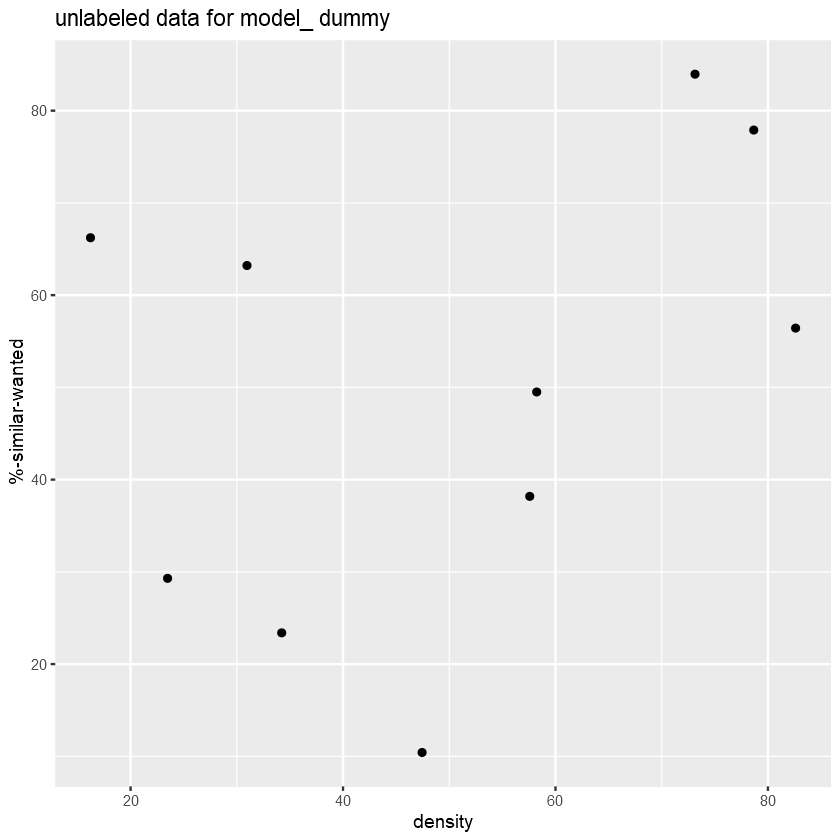

In [19]:
data_candidates_plot = ggplot(data = data_candidates[,.(density,`%-similar-wanted`)], aes(x = density, y = `%-similar-wanted`)) +
                    geom_point() +
                    ggtitle(paste0("unlabeled data for model_ ", model.type))
data_candidates_plot
ggsave(paste0(outputs.path,"unlabeled_", model.type,".png"))

#pca_unlabeled_pool <- princomp(data_candidates[,-c("idx")], cor = TRUE, scores = TRUE)
#pca_unlabeled_pool_components <- get_pca_ind(pca_unlabeled_pool)
#p_unlabeled_pool <- ggplot(data = data.table(pca_unlabeled_pool_components$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
#                    geom_point() +
#                    ggtitle(paste0("unlabeled data for model_ ", model.type)) 
#p_unlabeled_pool
#ggsave(paste0(outputs.path,"unlabeled_", model.type,".png"))

# Test Set

In [20]:
test_set.name= paste0(data.path,"test_set","_",model.type,"_",test_ins,".csv")
test_set <- fread(test_set.name)  

Saving 6.67 x 6.67 in image


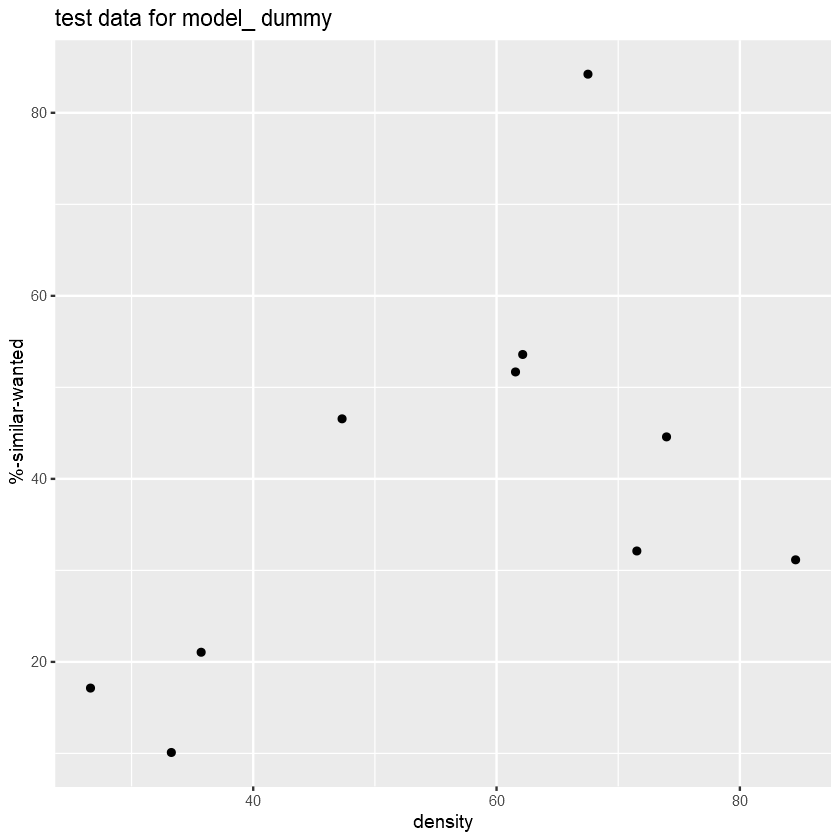

In [21]:
test_set_plot = ggplot(data = test_set[,.(density,`%-similar-wanted`)], aes(x = density, y = `%-similar-wanted`)) +
                    geom_point() +
                    ggtitle(paste0("test data for model_ ", model.type))
test_set_plot
ggsave(paste0(outputs.path,"test_set_", model.type,".png"))

#pca_test_set <- princomp(test_set, cor = TRUE, scores = TRUE)
#pca_test_set_components <- get_pca_ind(pca_test_set)
#p_test_set <- ggplot(data = data.table(pca_test_set_components$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
#                    geom_point() +
#                    ggtitle(paste0("test data for model_ ", model.type)) 
#p_test_set
#ggsave(paste0(outputs.path,"test_set_", model.type,".png"))

# Benchmark : One-shot sampling, No feature elimination

## One-Shot Training Set

In [22]:
training_set_all = data.table()

for( i in seed.oneshot){
    
    training_set.name= paste0(data.path,"training_set","_",model.type,"_",train_ins_oneshot,"_seed",i,".csv")
    training_set <- fread(training_set.name) 
    
    assign(paste0("training_set_",i),training_set)
    
    training_set_all = rbind(training_set_all,data.table(training_set, "seed" = i))
    rm(training_set,training_set.name)    
}

In [23]:
one_shot_data = copy(training_set_all)

### Visualization

Saving 6.67 x 6.67 in image


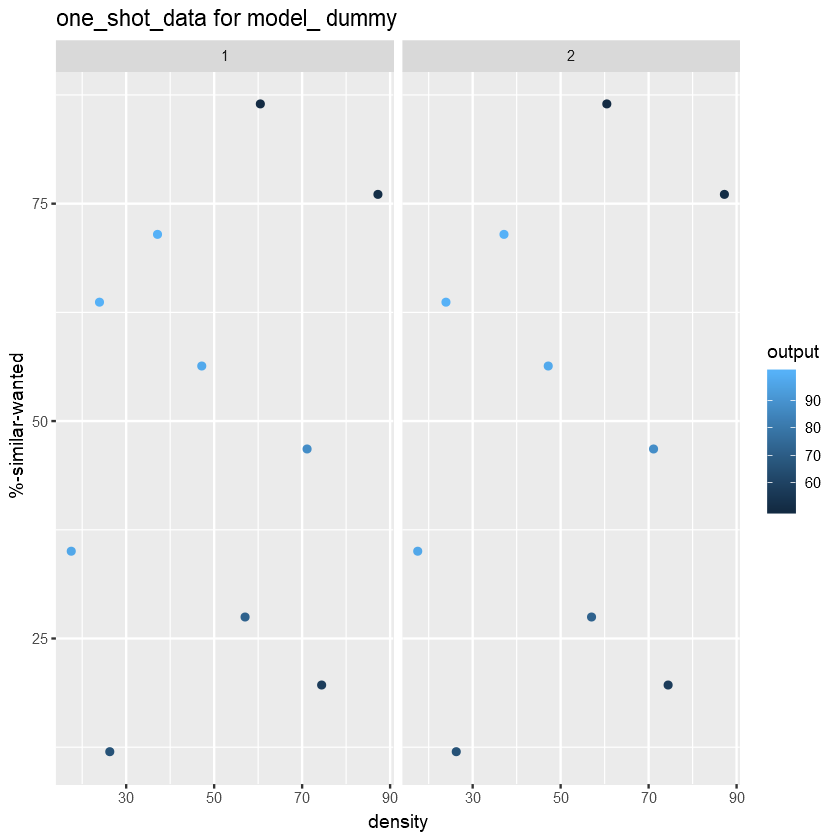

In [24]:
one_shot_plot = ggplot(data = one_shot_data, aes(x = density, y = `%-similar-wanted`)) +
                    geom_point(aes(colour = output)) +
                    facet_wrap(~ seed) +
                    labs(legend = "output") +
                    ggtitle(paste0("one_shot_data for model_ ", model.type))
one_shot_plot
ggsave(paste0(outputs.path,"one_shot_data_", model.type,".png"))

#pca_training_set <- princomp(training_set_all[,.SD, .SDcols = !c("output","seed")], cor = TRUE, scores = TRUE)
#
#pca_training_set_components <- get_pca_ind(pca_training_set)
#pca_training_set_components <-cbind(pca_training_set_components$coord[,1:2],training_set_all[,.SD, .SDcols = c("output","seed")])
#p_training_set <- ggplot(data = pca_training_set_components, aes(x = Dim.1, y = Dim.2)) +
#             geom_point(aes(colour = output)) +
#             facet_wrap(~ seed) +
#             labs(legend = "output") +
#             ggtitle(paste0("one_shot_data for model_ ", model.type)) 
#p_training_set
#ggsave(paste0(outputs.path,"one_shot_data_", model.type,".png"))

## Train & Test Metamodel

In [26]:
performance_table_oneshot = data.table(iter = numeric(),seed = numeric(), mae= numeric(),rmse= numeric(), mape = numeric())
predictedLabels_oneshot_all = data.table()
obb_error_oneshot_all = data.table(obb_error = numeric(),seed = numeric())

In [27]:
for( i in seed.oneshot){
    training_set = copy(one_shot_data[seed == i,.SD,.SDcols = -c("seed")])
    #tuning = tune.randomForest(x = training_set[, -c("output")], y = training_set$output, ntree = c(100,200,300,400), mtry = c(1, 2, 3), tunecontrol = tune.control(sampling = "cross", cross = length(training_set$output)))
    #model_oneshot <- randomForest(x = training_set[, -c("output")], y = training_set$output, importance = TRUE,ntree = as.numeric(tuning$best.parameters$ntree), mtry = as.numeric(tuning$best.parameters$mtry))
    model_oneshot <- randomForest(x = training_set[, -c("output")], y = training_set$output, importance = TRUE,ntree = ntree, mtry = mtry)
    model_Sub.path = paste0(outputs.path,"model_oneshot_seed_",i,".rds")    
    saveRDS(model_oneshot, model_Sub.path)
    
    obb_error_oneshot <- obb_error_func(model_oneshot)
    obb_error_oneshot_all = rbind(obb_error_oneshot_all,data.table(obb_error_oneshot,"seed" = i),use.names=FALSE)
    
    test_prediction_oneshot = get_test_predictions(model_oneshot,test_set,error_type)
    predictedLabels_oneshot = test_prediction_oneshot[[1]]
    
    predictedLabels_oneshot_all = rbind(predictedLabels_oneshot_all,data.table(predictedLabels_oneshot, "seed" = i))
    performance_table_oneshot = rbind(performance_table_oneshot, data.table(1,i, test_prediction_oneshot[[2]]), use.names = FALSE)
    output_variables = test_prediction_oneshot[[3]]   
    
    assign(paste0("model_oneshot_",i),model_oneshot)
    assign(paste0("obb_error_oneshot_",i),obb_error_oneshot)
    assign(paste0("test_prediction_oneshot_",i),test_prediction_oneshot)
    assign(paste0("predictedLabels_oneshot_",i),predictedLabels_oneshot)
    
    rm(training_set,tuning,model_oneshot,obb_error_oneshot,test_prediction_oneshot,predictedLabels_oneshot)   
}

In [28]:
fwrite(predictedLabels_oneshot_all, paste0(outputs.path,model.type,"_","predictedLabels_oneshot_all",".csv"))
fwrite(performance_table_oneshot, paste0(outputs.path,model.type,"_","performance_table_oneshot",".csv"))
fwrite(obb_error_oneshot_all, paste0(outputs.path,model.type,"_","obb_error_oneshot_all",".csv"))

In [29]:
performance_molten_oneshot <- melt(data = performance_table_oneshot
                             , id.vars = c('iter',"seed"))
setnames(performance_molten_oneshot, c("variable","value"),c("errortype","errorvalue"))

Saving 6.67 x 6.67 in image


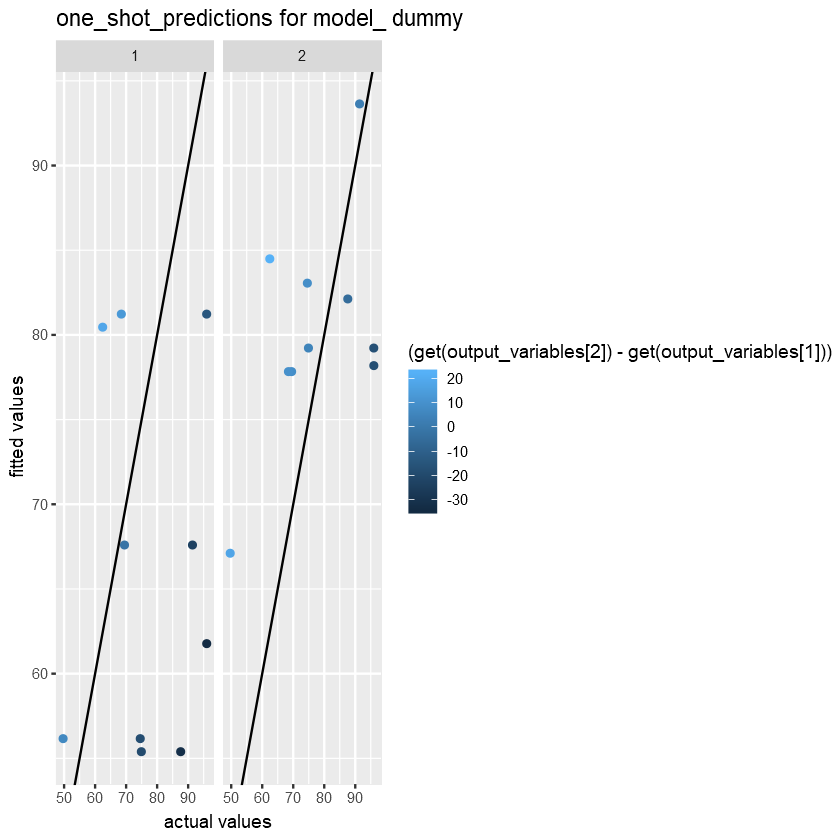

In [30]:
p_oneshot <- ggplot(predictedLabels_oneshot_all,aes(x = get(output_variables[1]), y = get(output_variables[2]), color = (get(output_variables[2]) - get(output_variables[1])))) +
            geom_point() +
            geom_abline() +
            facet_wrap(~ seed) + 
            xlab("actual values") +
            ylab("fitted values") +
            ggtitle(paste0("one_shot_predictions for model_ ", model.type)) 

p_oneshot
ggsave(paste0(outputs.path,"one_shot_predictions_", model.type,".png"))


# Random Sampling & No Feature Elimination

## Training Set

In [31]:
training_set_Ad_all = data.table()
for (i in seed.Ad) {
    
    training_set.name = paste0(data.path, "training_set", "_", model.type, "_", train_ins_Ad, "_seed", i, ".csv")
    training_set <- fread(training_set.name)
    
    assign(paste0("training_set_Ad_", i), training_set)
    
    training_set_Ad_all = rbind(training_set_Ad_all, data.table(training_set, seed = i))
    rm(training_set, training_set.name)
}

In [42]:
adaptive_initial_data = copy(training_set_Ad_all)

## Visualization

Saving 6.67 x 6.67 in image


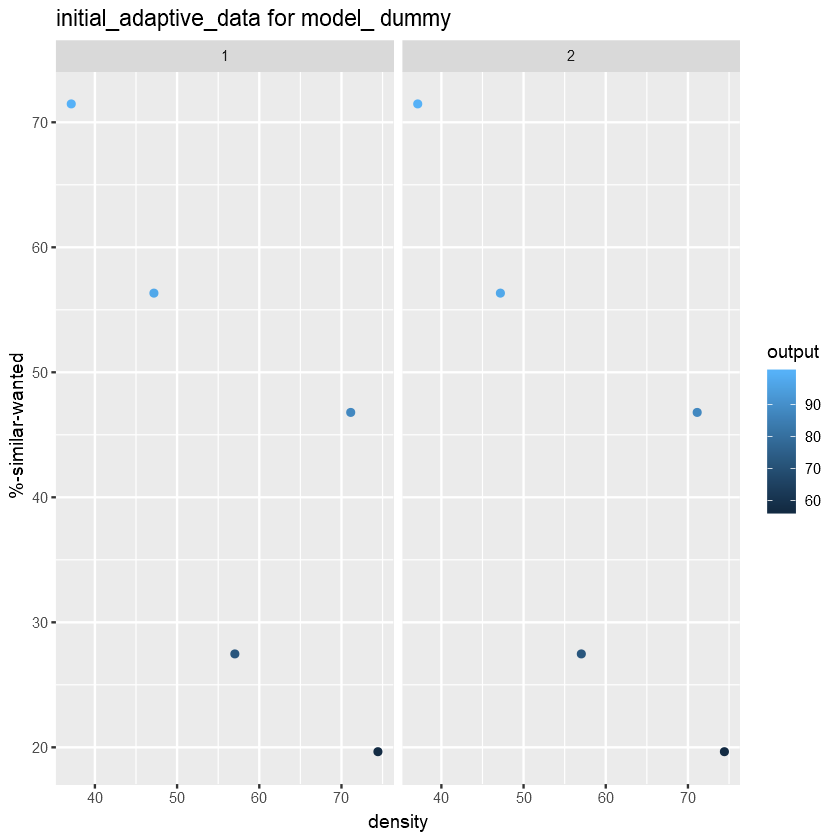

In [43]:
adaptive_initial_plot = ggplot(data = adaptive_initial_data, aes(x = density, y = `%-similar-wanted`)) +
                           geom_point(aes(colour = output)) +
                           facet_wrap(~seed) +
                           labs(legend = "output") +
                           ggtitle(paste0("initial_adaptive_data for model_ ", model.type))
adaptive_initial_plot
ggsave(paste0(outputs.path,"adaptive_initial_data_", model.type,".png"))

#pca_training_set_Ad <- princomp(adaptive_initial_data[, .SD, .SDcols = !c("output", "seed")], cor = TRUE, scores = TRUE)
#
#pca_training_set_Ad_components <- get_pca_ind(pca_training_set_Ad)
#pca_training_set_Ad_components <- cbind(pca_training_set_Ad_components$coord[, 1:2],adaptive_initial_data[, .SD, .SDcols = c("output", "seed")])
#p_training_set_Ad <- ggplot(data = pca_training_set_Ad_components, aes(x = Dim.1,y = Dim.2)) + 
#                        geom_point(aes(colour = output)) + 
#                        facet_wrap(~seed) + 
#                        labs(legend = "output") +
#                        ggtitle(paste0("initial_adaptive_data for model_ ", model.type)) 
#p_training_set_Ad
#ggsave(paste0(outputs.path,"adaptive_initial_data_", model.type,".png"))

## Train & Test Metamodel

In [44]:
# Record model performances
performance_table = data.table(iter = numeric(),seed = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())
# Record obb_error table
obb_error = data.table(iter = numeric() ,obb_error = numeric(),seed = numeric())
# Initialize record tables
predictedLabels_all = data.table()
train_candidates_all = data.table()
training_set_Ad_final = data.table()

In [45]:
for( i in seed.Ad){
set.seed(10)
print(paste0("seed : ",i,"  Random Sampling section start time : ",Sys.time()))
    
unlabeled_pool =copy(data_candidates)  
predictedLabels_table = copy(test_set)
    
train_candidates_table = data.table()
    
training_set_Ad = copy(adaptive_initial_data[seed == i,.SD,.SDcols = -c("seed")])
    
iter = 1
while(iter <= iteration_budget){   
    print(iter)

    trainx = training_set_Ad[,.SD, .SDcols = feature_names]
    trainy = training_set_Ad$output
    
    # Train the model
    model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry)
    assign(paste0("model_Rd_",iter,"_seed_",i),model_Sub)
    model_Sub.path = paste0(outputs.path,paste0("model_Rd_",iter,"_seed_",i),".rds")
    saveRDS(model_Sub, model_Sub.path)
                     
    obb_error = rbind(obb_error,data.table(iter,obb_error_func(model_Sub),i),use.names=FALSE)
    
    # test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub,test_set,error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub,c("pred_output",error_type), c(paste0("pred_output_",iter),paste0(error_type,"_",iter)))    
    predictedLabels_table = cbind(predictedLabels_table,predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_",iter),paste0(error_type,"_",iter))])
    
    # Keep test set error records
    performance_table = rbind(performance_table,data.table(iter,i,test_predictions_Sub[[2]]), use.names = FALSE)    
   
    if(iter != iteration_budget){ # below efforts are unnecessary when the budget is reached.
        
    ## sample selection from unlabeled data select candidates
    unlabeled_set <- copy(unlabeled_pool)
    train_candidates = random_sample_selection(selected_ins,unlabeled_set)
        
    # Eliminate train candidates from the unlabeled pool
    unlabeled_pool = unlabeled_pool[- train_candidates$idx]
    rm(unlabeled_set)
    
    # run ABM to find outputs of train candidates
    print(paste0("ABM train_candidate run start time : ",Sys.time()))
    train_candidates = run_ABM(nofrep,selected_ins,train_candidates)
    print(paste0("ABM train_candidate run end time : ",Sys.time()))
    
    train_candidates_table = rbind(train_candidates_table, data.table(train_candidates,iter = iter))

    # Add new data to train data
    training_set_Ad = rbind(training_set_Ad,train_candidates[,-c("idx")])
    }
    iter = iter + 1
}
# plot koy her iteration'da göstersin.
#setcolorder(data,variableorder) ################# bunu bi yerlere koyman gerekebilir, dikkat!!
print(paste0("seed : ",i,"  Random Sampling section end time : ",Sys.time()))
    
    assign(paste0("predictedLabels_table_",i),predictedLabels_table)
    assign(paste0("train_candidates_table_",i),train_candidates_table)
    
    training_set_Ad_final = rbind(training_set_Ad_final, data.table(training_set_Ad, "seed" = i))
    predictedLabels_all = rbind(predictedLabels_all,data.table(predictedLabels_table,"seed" = i))
    train_candidates_all = rbind(train_candidates_all,data.table(train_candidates_table,"seed" = i))
    
    rm(training_set_Ad,predictedLabels_table,train_candidates_table)
    }

[1] "seed : 1  Random Sampling section start time : 2020-01-17 22:46:44"
[1] 1
[1] "ABM train_candidate run start time : 2020-01-17 22:46:44"
[1] "ABM train_candidate run end time : 2020-01-17 22:46:49"
[1] 2
[1] "seed : 1  Random Sampling section end time : 2020-01-17 22:46:49"
[1] "seed : 2  Random Sampling section start time : 2020-01-17 22:46:49"
[1] 1
[1] "ABM train_candidate run start time : 2020-01-17 22:46:49"
[1] "ABM train_candidate run end time : 2020-01-17 22:46:51"
[1] 2
[1] "seed : 2  Random Sampling section end time : 2020-01-17 22:46:51"


In [46]:
# Final records
FinalTrainData_Rd = copy(training_set_Ad_final)
obb_error_Rd = copy(obb_error)
performance_table_Rd = copy(performance_table)
predictedLabels_table_Rd = copy(predictedLabels_all)
train_candidates_table_Rd  = copy(train_candidates_all)

# rm(training_set_Ad_final,obb_error,performance_table,predictedLabels_all,train_candidates_all)

In [47]:
fwrite(FinalTrainData_Rd,paste0(outputs.path,model.type,"_","FinalTrainData_Rd",".csv") )
fwrite(performance_table_Rd,paste0(outputs.path,model.type,"_","performance_table_Rd",".csv") )
fwrite(train_candidates_table_Rd,paste0(outputs.path,model.type,"_","train_candidates_table_Rd",".csv") )
fwrite(predictedLabels_table_Rd,paste0(outputs.path,model.type,"_","predictedLabels_table_Rd",".csv") )
fwrite(obb_error_Rd,paste0(outputs.path,model.type,"_","obb_error_Rd",".csv") )

In [48]:
# show results
nrow(FinalTrainData_Rd)
performance_table_Rd 
train_candidates_table_Rd  
head(predictedLabels_table_Rd)
obb_error_Rd

[1] 20

iter,seed,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,9.534285,16.15726,15.96999
2,1,8.599613,15.14574,14.29254
1,2,9.534285,16.15726,15.96999
2,2,8.620566,15.22677,14.33900


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,idx,output,iter,seed
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
30.95887,63.21681,3.628050,0.53090554,5.335035e-05,93.46226,1,99.62011,1,1
58.23511,49.50699,2.521896,0.85635518,5.731794e-05,100.66535,2,89.51412,1,1
16.22723,66.22745,4.305064,0.41218908,3.925965e-05,102.70253,4,98.81521,1,1
82.60701,56.42997,8.822197,0.91842707,8.411990e-05,91.75991,6,94.40424,1,1
34.22746,23.39281,1.216937,0.01528953,2.118902e-05,107.38797,7,73.24174,1,1
30.95887,63.21681,3.628050,0.53090554,5.335035e-05,93.46226,1,99.52947,1,2
58.23511,49.50699,2.521896,0.85635518,5.731794e-05,100.66535,2,89.27332,1,2
16.22723,66.22745,4.305064,0.41218908,3.925965e-05,102.70253,4,99.74164,1,2
82.60701,56.42997,8.822197,0.91842707,8.411990e-05,91.75991,6,94.68407,1,2


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,output,pred_output_1,RMSE_1,pred_output_2,RMSE_2,seed
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
47.30362,46.56359,3.013200,0.2160170,9.102479e-05,92.68219,91.39751,96.73226,5.3347568,98.10306,6.7055518,1
26.62587,17.14408,4.671323,0.6269176,3.598445e-05,91.34262,69.48202,72.07185,2.5898293,67.39606,2.0859572,1
73.97264,44.59131,6.533882,0.9352412,5.465928e-05,92.88922,87.59167,87.91120,0.3195275,93.28993,5.6982577,1
62.14971,53.59697,2.934764,0.1910999,8.883425e-05,96.90416,95.98850,96.73226,0.7437632,95.40756,0.5809365,1
35.72073,21.05795,6.969412,0.3990318,4.100930e-05,109.48962,68.45832,80.89291,12.4345985,67.39606,1.0622546,1
67.51420,84.22498,9.797524,0.3495696,3.372148e-05,95.61662,49.67705,96.73226,47.0552132,95.00151,45.3244623,1


iter,obb_error,seed
<dbl>,<dbl>,<dbl>
1,339.95835,1
2,70.01233,1
1,339.95835,2
2,71.42145,2


Saving 6.67 x 6.67 in image


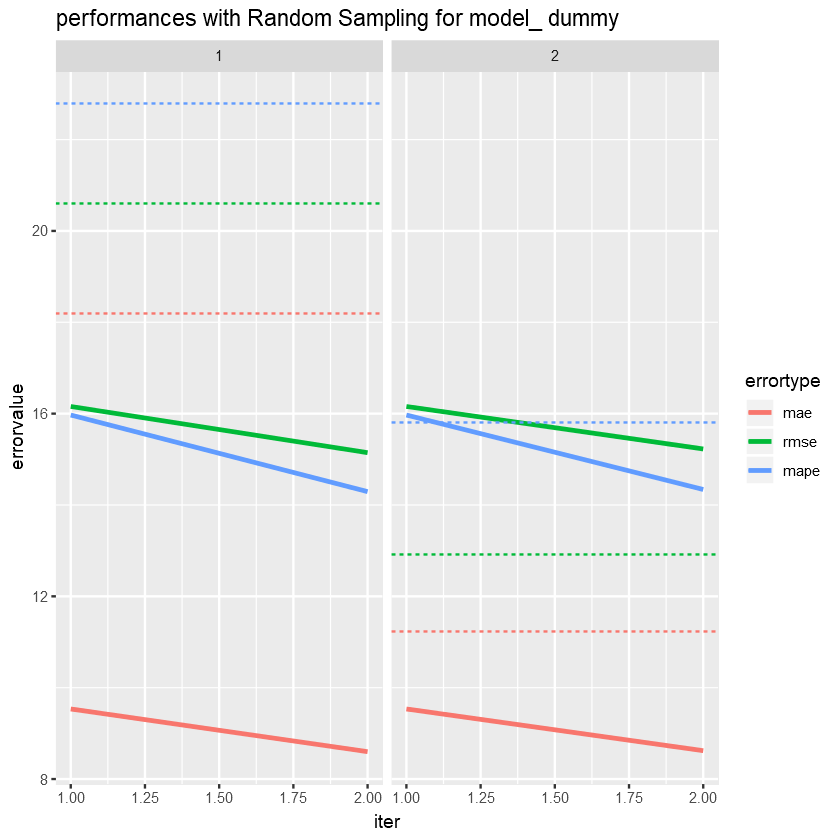

In [49]:
performance_molten_Rd <- melt(data = performance_table_Rd
                             , id.vars = c('iter',"seed"))
setnames(performance_molten_Rd, c("variable","value"),c("errortype","errorvalue"))
p_Rd = ggplot(performance_molten_Rd, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
          geom_line(lwd=1)+
          facet_wrap(~ seed) +
          geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
          ggtitle(paste0("performances with Random Sampling for model_ ", model.type))
p_Rd
ggsave(paste0(outputs.path,"performance_table_Rd_", model.type,".png"))

## Final Visualization

Saving 6.67 x 6.67 in image


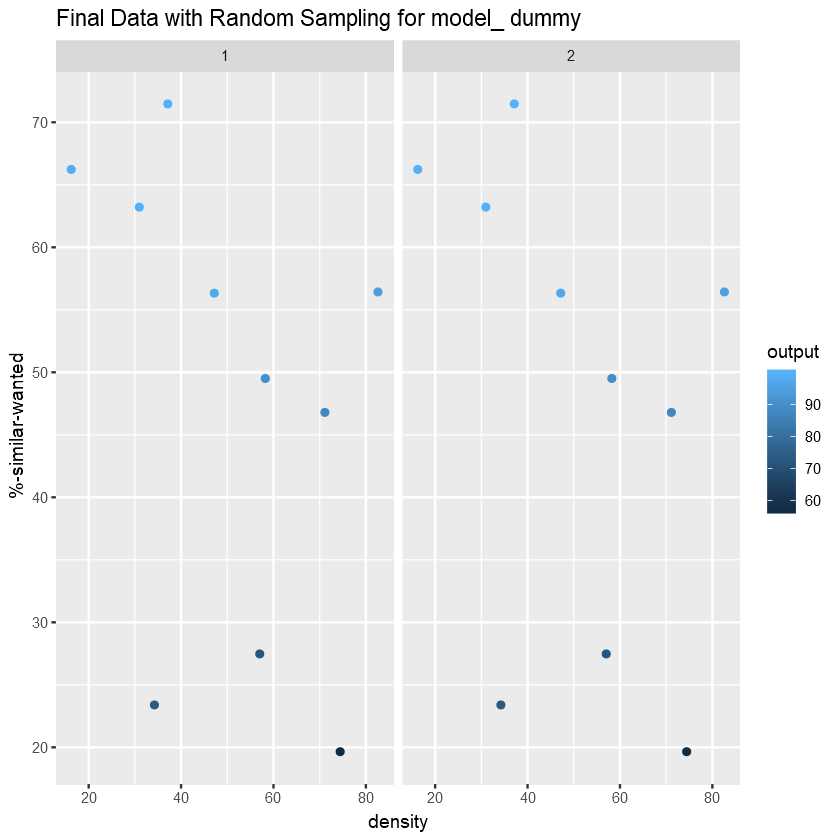

In [50]:
final_Rd_plot = ggplot(data = FinalTrainData_Rd, aes(x = density, y = `%-similar-wanted`)) +
                     geom_point(aes(colour = output)) +
                     facet_wrap(~ seed) +
                     labs(legend = "output") +
                     ggtitle(paste0("Final Data with Random Sampling for model_ ", model.type))
final_Rd_plot
ggsave(paste0(outputs.path,"FinalTrainData_Rd_", model.type,".png"))

#pca_final_Rd_training_set <- princomp(FinalTrainData_Rd[,.SD, .SDcols = !c("output","seed")], cor = TRUE, scores = TRUE)
#
#pca_final_Rd_training_set_components <- get_pca_ind(pca_final_Rd_training_set)
#pca_final_Rd_training_set_components <-cbind(pca_final_Rd_training_set_components$coord[,1:2],FinalTrainData_Rd[,.SD, .SDcols = c("output","seed")])
#p_final_Rd_training_set <- ggplot(data = pca_final_Rd_training_set_components, aes(x = Dim.1, y = Dim.2)) +
#             geom_point(aes(colour = output)) +
#             facet_wrap(~ seed) +
#             labs(legend = "output") +
#             ggtitle(paste0("Final Data with Random Sampling for model_ ", model.type)) 
#p_final_Rd_training_set
#ggsave(paste0(outputs.path,"FinalTrainData_Rd_", model.type,".png"))

png 
  2

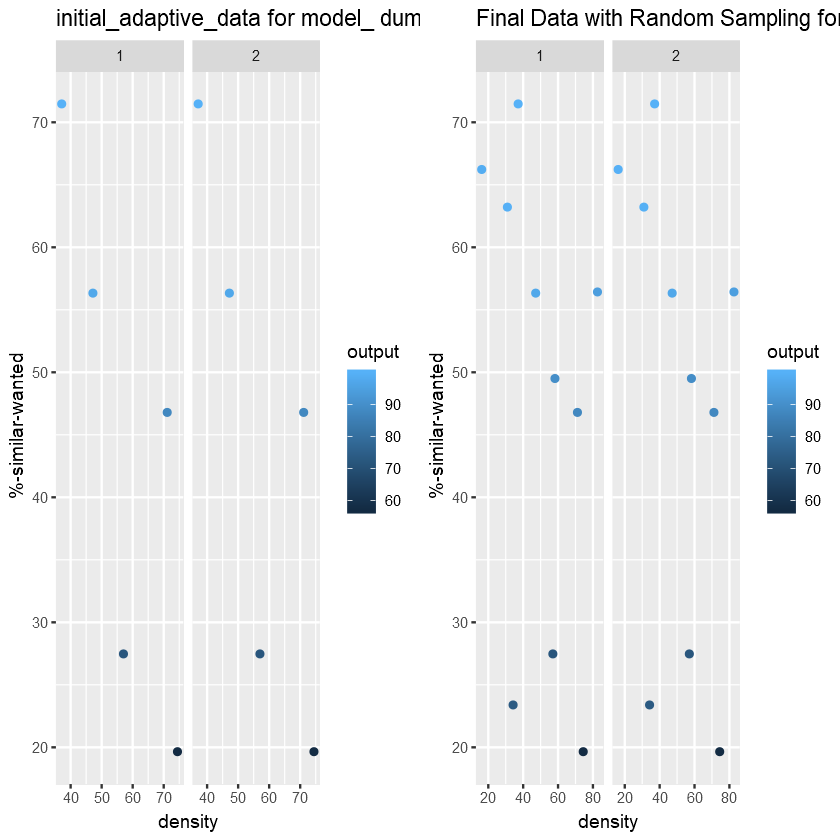

In [52]:
png(paste0(outputs.path,"TrainData_Rd_Before_After_", model.type,".png"))
grid.arrange(adaptive_initial_plot,final_Rd_plot, ncol=2)
dev.off()
grid.arrange(adaptive_initial_plot,final_Rd_plot, ncol=2)
#ggsave(paste0(outputs.path,"TrainData_Rd_Before_After_", model.type,".png"))

# Adaptive Sampling & No Feature Elimination

## Train & Test Metamodel

In [55]:
## initialize record tables Record train candidates
train_candidates_table = data.table()

# Record model performances
performance_table = data.table(iter = numeric(),seed = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())

# Record obb_error table
obb_error = data.table(iter = numeric(), obb_error = numeric(), seed = numeric())

## initialize variables
# keep test set undistorted
predictedLabels_table = copy(test_set)

predictedLabels_all = data.table()
train_candidates_all = data.table()
training_set_Ad_final = data.table()
importance_table_Ad = data.table()

In [56]:
for( i in seed.Ad){
set.seed(10)
print(paste0("seed : ",i,"  Adaptive Sampling section start time : ",Sys.time()))
 
    # keep sets undistorted
unlabeled_pool =copy(data_candidates)    
predictedLabels_table = copy(test_set)
training_set_Ad = copy(adaptive_initial_data[seed == i,.SD,.SDcols = -c("seed")])
    
train_candidates_table = data.table()
       
iter = 1
while(iter <= iteration_budget){   
    print(iter)

    trainx = training_set_Ad[,.SD, .SDcols = feature_names]
    trainy = training_set_Ad$output
    
    # Train the model
    model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry)
    assign(paste0("model_Ad_",iter,"_seed_",i),model_Sub)
    model_Sub.path = paste0(outputs.path,paste0("model_Ad_",iter,"_seed_",i),".rds")
    saveRDS(model_Sub, model_Sub.path)
                    
    obb_error = rbind(obb_error,data.table(iter,obb_error_func(model_Sub),i),use.names=FALSE)

    # test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub,test_set,error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub,c("pred_output",error_type), c(paste0("pred_output_",iter),paste0(error_type,"_",iter)))    
    predictedLabels_table = cbind(predictedLabels_table,predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_",iter),paste0(error_type,"_",iter))])
    
    # Keep test set error records
    performance_table = rbind(performance_table,data.table(iter,i,test_predictions_Sub[[2]]), use.names = FALSE)
    
    if(iter != iteration_budget){ # below efforts are unnecessary when the budget is reached.    
    ## sample selection from unlabeled data select candidates
        unlabeled_set <- copy(unlabeled_pool)
        train_candidates = sample_selection(selected_ins, unlabeled_set, model_Sub)
        
        # eliminate candidates from the unlabeled pool
        unlabeled_pool = unlabeled_pool[-train_candidates$idx]
        rm(unlabeled_set)
        
        # run ABM to find outputs of train candidates
        print(paste0("ABM train_candidate run start time : ",Sys.time()))
        train_candidates = run_ABM(nofrep, selected_ins, train_candidates)
        print(paste0("ABM train_candidate run end time : ",Sys.time()))
        
        train_candidates_table = rbind(train_candidates_table, data.table(train_candidates,iter = iter))
        
        # add labeled candidates to the train data
        training_set_Ad = rbind(training_set_Ad, train_candidates[, -c("idx")])
    }
    
    importance_table_Ad = rbind(importance_table_Ad, data.table(seed = i, iter_no = iter, 
        t(importance(get(paste0("model_Ad_", iter, "_seed_", i)), type = 1, scale = FALSE))))

    iter = iter + 1
}
print(paste0("seed : ",i,"  Adaptive Sampling section end time : ",Sys.time()))
    
assign(paste0("predictedLabels_table_",i),predictedLabels_table)
assign(paste0("train_candidates_table_",i),train_candidates_table)

training_set_Ad_final = rbind(training_set_Ad_final, data.table(training_set_Ad, "seed" = i))
predictedLabels_all = rbind(predictedLabels_all,data.table(predictedLabels_table,"seed" = i))
train_candidates_all = rbind(train_candidates_all,data.table(train_candidates_table,"seed" = i))

rm(training_set_Ad,predictedLabels_table,train_candidates_table)      
}

[1] "seed : 1  Adaptive Sampling section start time : 2020-01-17 22:52:04"
[1] 1
[1] "ABM train_candidate run start time : 2020-01-17 22:52:04"
[1] "ABM train_candidate run end time : 2020-01-17 22:52:07"
[1] 2
[1] "seed : 1  Adaptive Sampling section end time : 2020-01-17 22:52:07"
[1] "seed : 2  Adaptive Sampling section start time : 2020-01-17 22:52:07"
[1] 1
[1] "ABM train_candidate run start time : 2020-01-17 22:52:07"
[1] "ABM train_candidate run end time : 2020-01-17 22:52:09"
[1] 2
[1] "seed : 2  Adaptive Sampling section end time : 2020-01-17 22:52:09"


In [58]:
# Final records
FinalTrainData_Ad = copy(training_set_Ad_final)
obb_error_Ad = copy(obb_error)
performance_table_Ad = copy(performance_table)
predictedLabels_table_Ad = copy(predictedLabels_all)
train_candidates_table_Ad  = copy(train_candidates_all)

In [ ]:
rm(training_set_Ad_final,obb_error,performance_table,predictedLabels_all,train_candidates_all)

In [59]:
fwrite(importance_table_Ad,paste0(outputs.path,model.type,"_","importance_table_Ad",".csv") )
fwrite(FinalTrainData_Ad,paste0(outputs.path,model.type,"_","FinalTrainData_Ad",".csv") )
fwrite(performance_table_Ad,paste0(outputs.path,model.type,"_","performance_table_Ad",".csv") )
fwrite(train_candidates_table_Ad,paste0(outputs.path,model.type,"_","train_candidates_table_Ad",".csv") )
fwrite(predictedLabels_table_Ad,paste0(outputs.path,model.type,"_","predictedLabels_table_Ad",".csv") )
fwrite(obb_error_Ad,paste0(outputs.path,model.type,"_","obb_error_Ad",".csv") )

In [61]:
head(importance_table_Ad)
nrow(FinalTrainData_Ad)
performance_table_Ad
train_candidates_table_Ad
head(predictedLabels_table_Ad)
obb_error_Ad

seed,iter_no,density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,0.00000,0,0.00000,0,0
1,2,0,98.66651,0,20.42200,0,0
2,1,0,0.00000,0,0.00000,0,0
2,2,0,157.87010,0,23.21789,0,0


[1] 20

iter,seed,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,9.534285,16.15726,15.96999
2,1,7.964624,12.77645,12.69623
1,2,9.534285,16.15726,15.96999
2,2,8.161469,12.74981,12.92213


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,idx,output,iter,seed
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
47.44334,10.42196,9.618603,0.11017768,6.769257e-05,96.73668,5,57.41452,1,1
34.22746,23.39281,1.216937,0.01528953,2.118902e-05,107.38797,7,69.01101,1,1
58.23511,49.50699,2.521896,0.85635518,5.731794e-05,100.66535,2,88.88336,1,1
82.60701,56.42997,8.822197,0.91842707,8.411990e-05,91.75991,6,94.49562,1,1
57.57891,38.18858,4.902821,0.70068462,1.098069e-05,95.19113,10,82.74155,1,1
47.44334,10.42196,9.618603,0.11017768,6.769257e-05,96.73668,5,57.49315,1,2
34.22746,23.39281,1.216937,0.01528953,2.118902e-05,107.38797,7,69.39778,1,2
58.23511,49.50699,2.521896,0.85635518,5.731794e-05,100.66535,2,90.63418,1,2
82.60701,56.42997,8.822197,0.91842707,8.411990e-05,91.75991,6,94.30011,1,2


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,output,pred_output_1,RMSE_1,pred_output_2,RMSE_2,seed
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
47.30362,46.56359,3.013200,0.2160170,9.102479e-05,92.68219,91.39751,96.73226,5.3347568,92.60823,1.210729,1
26.62587,17.14408,4.671323,0.6269176,3.598445e-05,91.34262,69.48202,72.07185,2.5898293,74.06839,4.586371,1
73.97264,44.59131,6.533882,0.9352412,5.465928e-05,92.88922,87.59167,87.91120,0.3195275,94.38893,6.797258,1
62.14971,53.59697,2.934764,0.1910999,8.883425e-05,96.90416,95.98850,96.73226,0.7437632,92.29825,3.690246,1
35.72073,21.05795,6.969412,0.3990318,4.100930e-05,109.48962,68.45832,80.89291,12.4345985,65.55152,2.906795,1
67.51420,84.22498,9.797524,0.3495696,3.372148e-05,95.61662,49.67705,96.73226,47.0552132,85.87206,36.195007,1


iter,obb_error,seed
<dbl>,<dbl>,<dbl>
1,339.9583,1
2,360.0809,1
1,339.9583,2
2,365.6015,2


Saving 6.67 x 6.67 in image


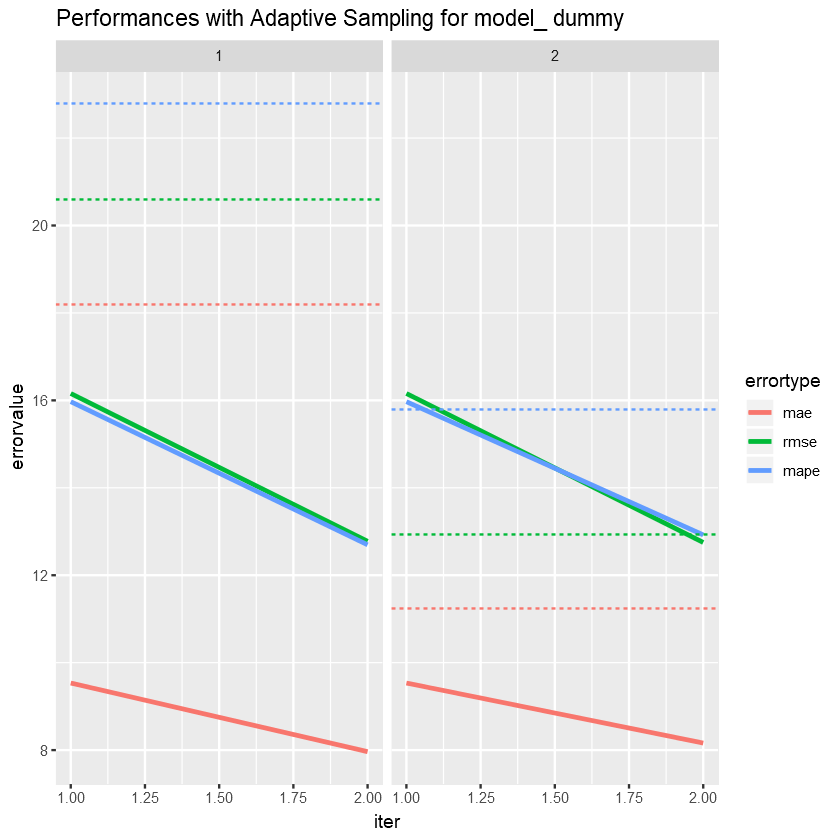

In [62]:
performance_molten_Ad <- melt(data = performance_table_Ad
                             , id.vars = c('iter',"seed"))
setnames(performance_molten_Ad, c("variable","value"),c("errortype","errorvalue"))
p_Ad = ggplot(performance_molten_Ad, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1)+
            facet_wrap(~ seed) +
            geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
            ggtitle(paste0("Performances with Adaptive Sampling for model_ ", model.type))
p_Ad
ggsave(paste0(outputs.path,"performance_table_Ad_", model.type,".png"))

## Final Visualization

Saving 6.67 x 6.67 in image


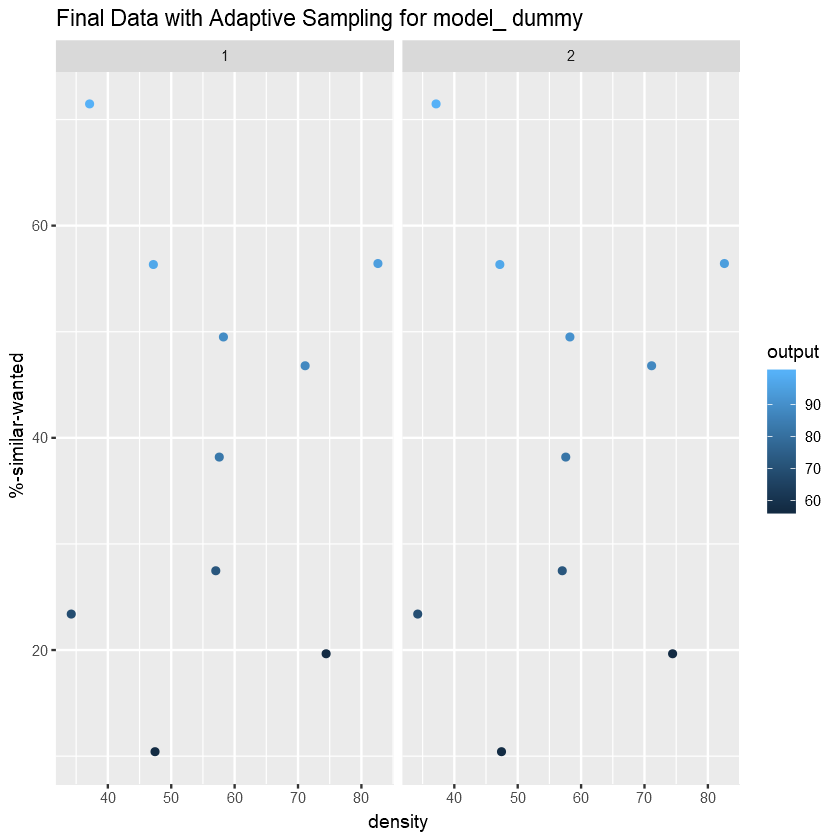

In [63]:
final_Ad_plot = ggplot(data = FinalTrainData_Ad, aes(x = density, y = `%-similar-wanted`)) +
                     geom_point(aes(colour = output)) +
                     facet_wrap(~ seed) +
                     labs(legend = "output") +
                     ggtitle(paste0("Final Data with Adaptive Sampling for model_ ", model.type))
final_Ad_plot
ggsave(paste0(outputs.path,"FinalTrainData_Ad_", model.type,".png"))

#pca_final_Ad_training_set <- princomp(FinalTrainData_Ad[,.SD, .SDcols = !c("output","seed")], cor = TRUE, scores = TRUE)
#
#pca_final_Ad_training_set_components <- get_pca_ind(pca_final_Ad_training_set)
#pca_final_Ad_training_set_components <-cbind(pca_final_Ad_training_set_components$coord[,1:2],FinalTrainData_Ad[,.SD, .SDcols = c("output","seed")])
#p_final_Ad_training_set <- ggplot(data = pca_final_Ad_training_set_components, aes(x = Dim.1, y = Dim.2)) +
#             geom_point(aes(colour = output)) +
#             facet_wrap(~ seed) +
#             labs(legend = "output") +
#             ggtitle(paste0("Final Data with Adaptive Sampling for model_ ", model.type)) 
#p_final_Ad_training_set
#ggsave(paste0(outputs.path,"FinalTrainData_Ad_", model.type,".png"))

png 
  2

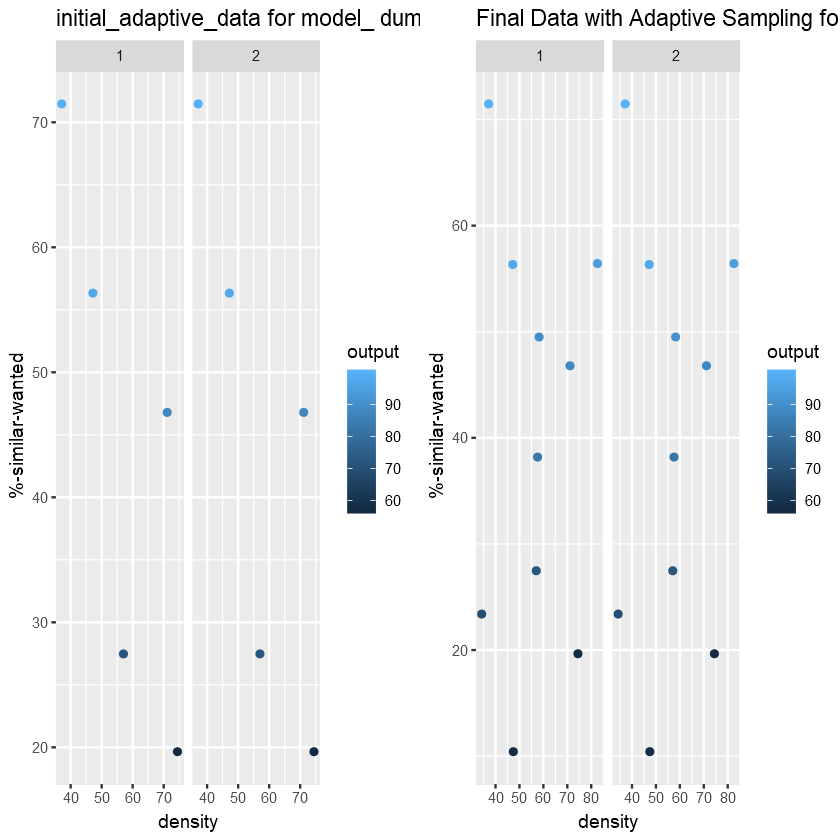

In [64]:
png(paste0(outputs.path,"TrainData_Ad_Before_After_", model.type,".png"))
grid.arrange(adaptive_initial_plot,final_Ad_plot, ncol=2)
dev.off()
grid.arrange(adaptive_initial_plot,final_Ad_plot, ncol=2)
#ggsave(paste0(outputs.path,"TrainData_Ad_Before_After_", model.type,".png"))

# 3 Scenarios

In [65]:
nrow(FinalTrainData_Ad)
nrow(one_shot_data)
nrow(FinalTrainData_Rd)

[1] 20

[1] 20

[1] 20

In [66]:
pred_oneshot_table = data.table()
pred_rd_table = data.table()
pred_ad_table = data.table()

for (i in seed.oneshot) {   
    training_set = copy(one_shot_data[seed == i, .SD, .SDcols = -c("seed")])
    
    oneshot_model = randomForest(x = training_set[, -c("output")], y = training_set$output, 
        importance = TRUE, ntree = ntree, mtry = mtry)   
    assign(paste0("oneshot_model_", i), oneshot_model)
    
    pred_oneshot <- predict(oneshot_model, test_set)
    pred_oneshot <- cbind(test_set, pred_oneshot)
    pred_oneshot_table = rbind(pred_oneshot_table, data.table(pred_oneshot, seed = i))
    
    # pred_oneshot[, `:=`(RMSE, mapply(function(x, y) rmse_func(x, y), output, pred_oneshot))]
    
    assign(paste0("pred_oneshot_", i), pred_oneshot)
}


for (i in seed.Ad) {   
    training_set = copy(FinalTrainData_Rd[seed == i, .SD, .SDcols = -c("seed")])
    
    random_model = randomForest(x = training_set[, .SD, .SDcols = feature_names], 
        y = training_set$output, importance = TRUE, ntree = ntree, mtry = mtry)   
    assign(paste0("random_model_", i), random_model)
    
    pred_rd <- predict(random_model, test_set)
    pred_rd <- cbind(test_set, pred_rd)
    pred_rd_table = rbind(pred_rd_table, data.table(pred_rd, seed = i))
    
    # pred_rd[, `:=`(RMSE, mapply(function(x, y) rmse_func(x, y), output, pred_rd))]
    assign(paste0("pred_rd_", i), pred_rd)
    
    
    training_set = copy(FinalTrainData_Ad[seed == i, .SD, .SDcols = -c("seed")])
    
    adaptive_model = randomForest(x = training_set[, .SD, .SDcols = feature_names], 
        y = training_set$output, importance = TRUE, ntree = ntree, mtry = mtry)
    assign(paste0("adaptive_model_", i), adaptive_model)
    
    pred_ad <- predict(adaptive_model, test_set)
    pred_ad <- cbind(test_set, pred_ad)
    pred_ad_table = rbind(pred_ad_table, data.table(pred_ad, seed = i))
    
    # pred_ad[, `:=`(RMSE, mapply(function(x, y) rmse_func(x, y), output, pred_ad))]
    assign(paste0("pred_ad_", i), pred_ad)
}

In [67]:
for (i in seed.oneshot) {
    print(paste0("seed: ",i))
print(rmse(pred_oneshot_table[seed == i]$output,pred_oneshot_table[seed == i]$pred_oneshot))
    }
for (i in seed.Ad) {
    print(paste0("seed: ",i))
print(rmse(pred_rd_table[seed == i]$output,pred_rd_table[seed == i]$pred_rd))
print(rmse(pred_ad_table[seed == i]$output,pred_ad_table[seed == i]$pred_ad))
    }

[1] "seed: 1"
[1] 20.25139
[1] "seed: 2"
[1] 24.85517
[1] "seed: 1"
[1] 15.04257
[1] 17.63059
[1] "seed: 2"
[1] 20.5508
[1] 13.80251


In [68]:
fwrite(pred_oneshot_table,paste0(outputs.path,model.type,"_","3scenario_oneshot",".csv") )
fwrite(pred_rd_table,paste0(outputs.path,model.type,"_","3scenario_rd",".csv") )
fwrite(pred_ad_table,paste0(outputs.path,model.type,"_","3scenario_ad",".csv") )

# Random Sampling vs Uncertainty Sampling

## Final Data Comparison

png 
  2

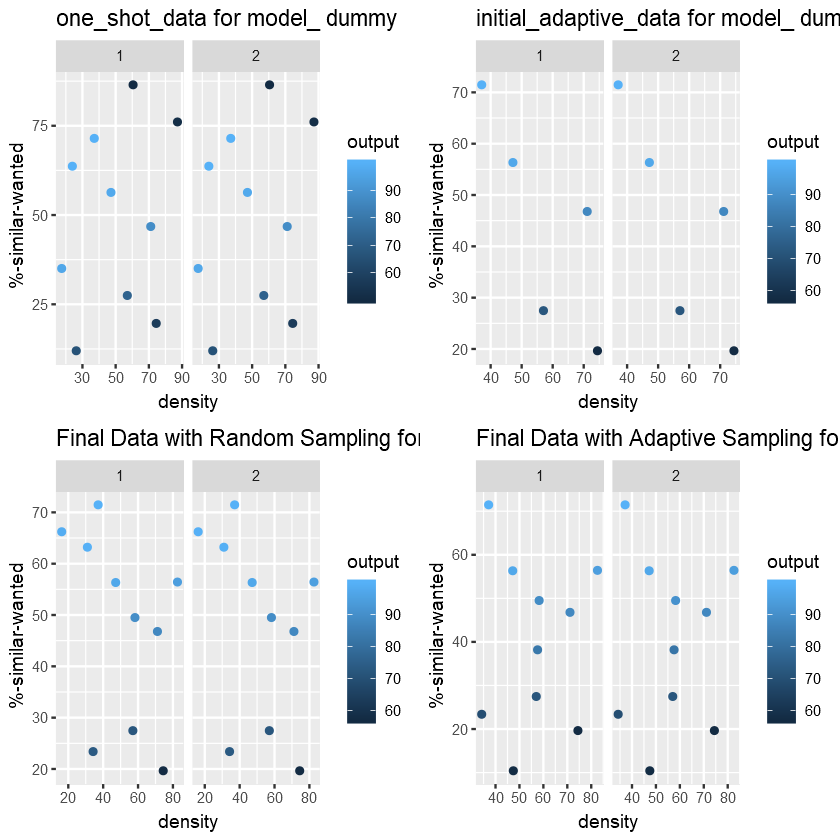

In [69]:
png(paste0(outputs.path,"TrainData_Rd&Ad_Before_After_", model.type,".png"))
grid.arrange(one_shot_plot, adaptive_initial_plot,final_Rd_plot,final_Ad_plot,nrow=2, ncol=2)
dev.off()
grid.arrange(one_shot_plot, adaptive_initial_plot,final_Rd_plot,final_Ad_plot,nrow=2, ncol=2)

#ggsave(paste0(outputs.path,"TrainData_Rd&Ad_Before_After_", model.type,".png"))

## Performance Comparison

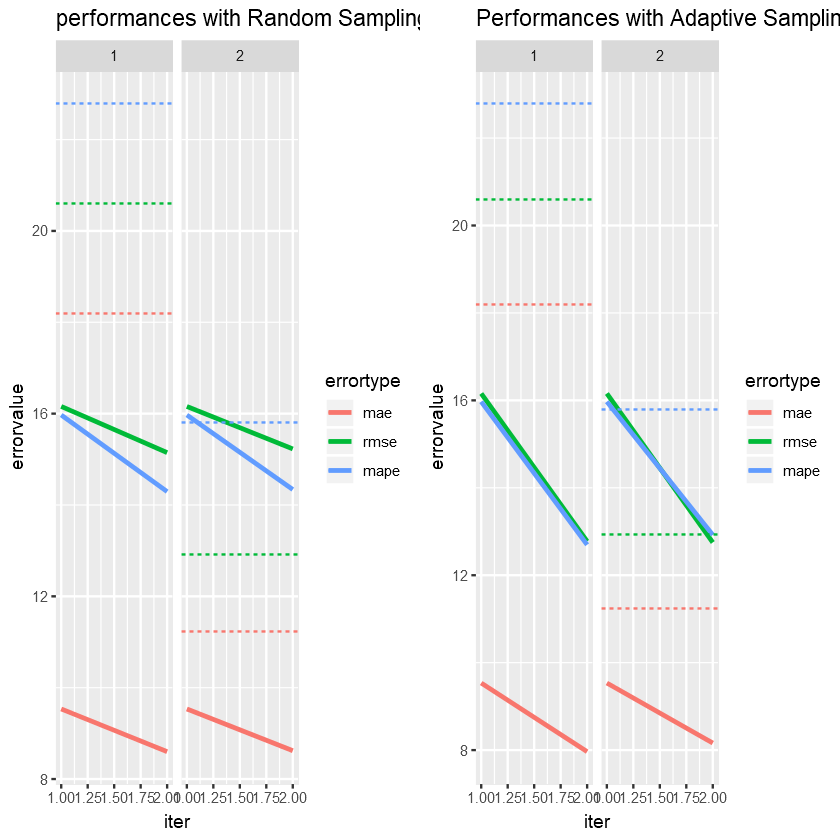

In [70]:
grid.arrange(p_Rd, p_Ad, ncol=2)

Saving 6.67 x 6.67 in image


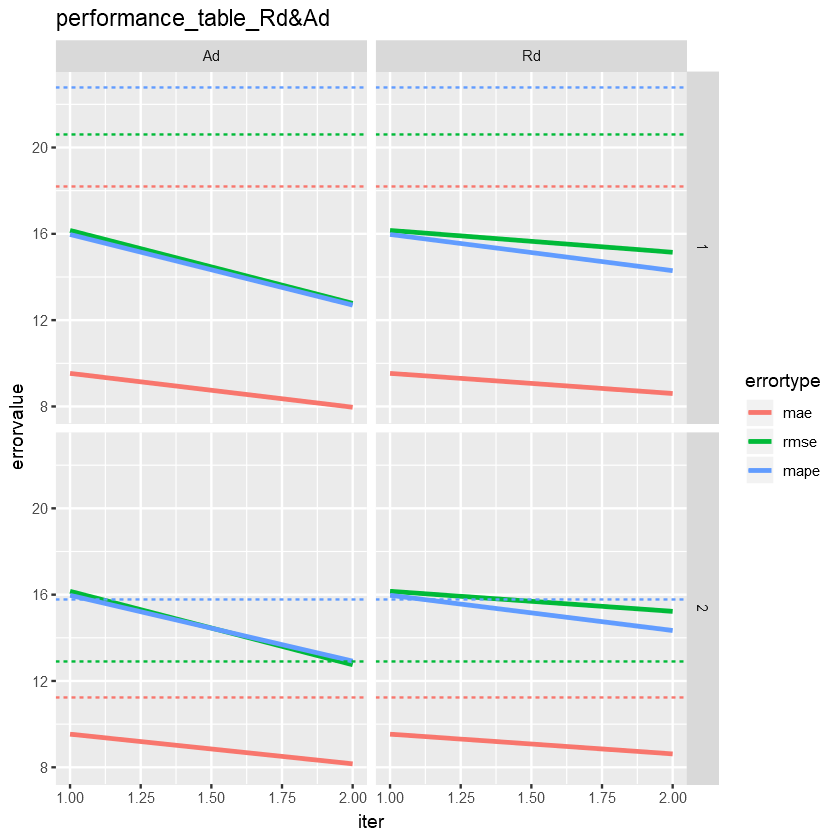

In [71]:
performance_Rd_vs_Ad = rbind(performance_molten_Rd[,.(iter,seed,errortype,errorvalue, type = "Rd")],performance_molten_Ad[,.(iter,seed,errortype,errorvalue, type = "Ad")])
p_Rd_vs_Ad = ggplot(performance_Rd_vs_Ad, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1) +
            geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
            facet_grid( seed ~ type ) +
            ggtitle("performance_table_Rd&Ad")
p_Rd_vs_Ad
ggsave(paste0(outputs.path,"performance_table_Rd&Ad_", model.type,".png"))

In [ ]:
ggplotly(p_Rd_vs_Ad)

# Adaptive Sampling & Feature Elimination 

## Train and Test Metamodel

In [72]:
# Decide on strategy:
# Decide on strategy:
if (model.type == "basic") {
    sample_selection_iteration_order = c(1:(iteration_budget - 1))
    feature_elimination_iteration_order = c(iteration_budget - 1)
} else if (model.type == "dummy") {
    sample_selection_iteration_order = c(1:(iteration_budget - 1))
    feature_elimination_iteration_order = c((iteration_budget - 4):(iteration_budget - 1))
}

In [73]:
# Record model performances
performance_table = data.table(iter = numeric(),seed = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())

# Record obb_error table
obb_error = data.table(iter = numeric(), obb_error = numeric(),seed = numeric())

# specify variables(columns) to be used initialize
columns_left = feature_names
total_numof_eliminated_vars <- 0

predictedLabels_all = data.table()
train_candidates_all = data.table()
training_set_Ad_final = data.table()


In [74]:
for( i in seed.Ad){
set.seed(10)
print(paste0("seed : ",i, "   section start time : ",Sys.time()))
 
    # keep sets undistorted
unlabeled_pool =copy(data_candidates)    
predictedLabels_table = copy(test_set)
training_set_Ad = copy(adaptive_initial_data[seed == i,.SD,.SDcols = -c("seed")])
  
train_candidates_table = data.table()
iteration_history = data.table(iter_no = numeric(), IsFeatureEliminated = logical(), IsDataSelected = logical())
    
columns_left = feature_names
total_numof_eliminated_vars <- 0
    
iter = 1
while(iter <= iteration_budget){   
    print(iter)

    trainx = training_set_Ad[,.SD, .SDcols = columns_left]
    trainy = training_set_Ad$output
    
    # Train the model
    model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry)
    assign(paste0("model_AdFe_",iter,"_seed_",i),model_Sub)
    model_Sub.path = paste0(outputs.path,paste0("model_AdFe_",iter,"_seed_",i),".rds")
    saveRDS(model_Sub, model_Sub.path)
    
    if (length(columns_left) == length(feature_names)) {
        ranked_features = get_variable_importance(model_Sub)
    }
    
    obb_error = rbind(obb_error,data.table(iter,obb_error_func(model_Sub),i),use.names=FALSE)

    # test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub,test_set,error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub,c("pred_output",error_type), c(paste0("pred_output_",iter),paste0(error_type,"_",iter)))    
    predictedLabels_table = cbind(predictedLabels_table,predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_",iter),paste0(error_type,"_",iter))])
    
    # Keep test set error records
    performance_table = rbind(performance_table,data.table(iter,i,test_predictions_Sub[[2]]), use.names = FALSE)
    
    # update iteration_history
    iteration_history = rbind(iteration_history, data.table(iter, 0, 0), use.names = FALSE)
    
    
    if(iter != iteration_budget){ # below efforts are unnecessary when the budget is reached.    
        if (iter %in% sample_selection_iteration_order) {
        ## sample selection from unlabeled data select candidates
        unlabeled_set <- copy(unlabeled_pool)
        train_candidates = sample_selection(selected_ins, unlabeled_set, model_Sub)
        
        # eliminate candidates from the unlabeled pool
        unlabeled_pool = unlabeled_pool[-train_candidates$idx]
        rm(unlabeled_set)
        
        # run ABM to find outputs of train candidates
        print(paste0("ABM train_candidate run start time : ",Sys.time()))
        train_candidates = run_ABM(nofrep, selected_ins, train_candidates)
        print(paste0("ABM train_candidate run end time : ",Sys.time()))
        
        train_candidates_table = rbind(train_candidates_table, data.table(train_candidates,iter = iter))
        
        # add labeled candidates to the train data
        training_set_Ad = rbind(training_set_Ad, train_candidates[, -c("idx")])
    
        # update iteration_history
         iteration_history[iter]$IsDataSelected= 1
        }
        if (iter %in% feature_elimination_iteration_order) {
            ## feature elimination apply feature elimination
            feature_elimination_result = feature_elimination(h, total_numof_eliminated_vars, ranked_features)
            
            columns_left = feature_elimination_result[[1]]  # 
            eliminated_columns = feature_elimination_result[[4]]  #   not necessary
            total_numof_eliminated_vars = as.numeric(feature_elimination_result[2])
            numof_eliminated_vars = as.numeric(feature_elimination_result[3])  #   not necessary 
            
            # update iteration_history
            iteration_history[iter]$IsFeatureEliminated= 1
        }
    }
    iter = iter + 1
}
print(paste0("seed : ",i,"   section end time : ",Sys.time()))

assign(paste0("columns_left_",i),columns_left)
assign(paste0("predictedLabels_table_",i),predictedLabels_table)
assign(paste0("train_candidates_table_",i),train_candidates_table)

training_set_Ad_final = rbind(training_set_Ad_final, data.table(training_set_Ad, "seed" = i))
predictedLabels_all = rbind(predictedLabels_all,data.table(predictedLabels_table,"seed" = i))
train_candidates_all = rbind(train_candidates_all,data.table(train_candidates_table,"seed" = i))

rm(training_set_Ad,predictedLabels_table,train_candidates_table)    
    
    
}

[1] "seed : 1   section start time : 2020-01-17 22:59:15"
[1] 1
[1] "ABM train_candidate run start time : 2020-01-17 22:59:15"
[1] "ABM train_candidate run end time : 2020-01-17 22:59:18"
[1] 2
[1] "seed : 1   section end time : 2020-01-17 22:59:18"
[1] "seed : 2   section start time : 2020-01-17 22:59:18"
[1] 1
[1] "ABM train_candidate run start time : 2020-01-17 22:59:18"
[1] "ABM train_candidate run end time : 2020-01-17 22:59:21"
[1] 2
[1] "seed : 2   section end time : 2020-01-17 22:59:21"


In [75]:

importance_table_AdFe = data.table()

for (i in seed.Ad) {
    iter = 1
    while (iter <= (iteration_budget - 4)) {
        importance_table_AdFe = rbind(importance_table_AdFe, data.table(seed = i, iter_no = iter, 
            t(importance(get(paste0("model_AdFe_", iter, "_seed_", i)), type = 1, scale = FALSE))))
        iter = iter + 1
    }
}

In [76]:
iteration_history

iter_no,IsFeatureEliminated,IsDataSelected
<dbl>,<dbl>,<dbl>
1,1,1
2,0,0


In [77]:
# Final records
FinalTrainData_AdFe = copy(training_set_Ad_final)
obb_error_AdFe = copy(obb_error)
performance_table_AdFe = copy(performance_table)
predictedLabels_table_AdFe = copy(predictedLabels_all)
train_candidates_table_AdFe  = copy(train_candidates_all)

In [ ]:
rm(training_set_Ad_final,obb_error,performance_table,predictedLabels_all,train_candidates_all)

In [78]:
fwrite(importance_table_AdFe,paste0(outputs.path,model.type,"_","importance_table_AdFe",".csv") )
fwrite(FinalTrainData_AdFe,paste0(outputs.path,model.type,"_","FinalTrainData_AdFe",".csv") )
fwrite(performance_table_AdFe,paste0(outputs.path,model.type,"_","performance_table_AdFe",".csv") )
fwrite(train_candidates_table_AdFe,paste0(outputs.path,model.type,"_","train_candidates_table_AdFe",".csv") )
fwrite(predictedLabels_table_AdFe,paste0(outputs.path,model.type,"_","predictedLabels_table_AdFe",".csv") )
fwrite(obb_error_AdFe,paste0(outputs.path,model.type,"_","obb_error_AdFe",".csv") )
fwrite(iteration_history,paste0(outputs.path,model.type,"_","iteration_history",".csv") )

In [79]:
nrow(FinalTrainData_AdFe)
performance_table_AdFe
train_candidates_table_AdFe
head(predictedLabels_table_AdFe)
obb_error_AdFe

[1] 20

iter,seed,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,9.534285,16.15726,15.96999
2,1,9.173931,12.81964,14.14953
1,2,9.534285,16.15726,15.96999
2,2,8.670833,14.64948,14.29403


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,idx,output,iter,seed
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
47.44334,10.42196,9.618603,0.11017768,6.769257e-05,96.73668,5,57.03949,1,1
34.22746,23.39281,1.216937,0.01528953,2.118902e-05,107.38797,7,65.25954,1,1
58.23511,49.50699,2.521896,0.85635518,5.731794e-05,100.66535,2,88.72306,1,1
82.60701,56.42997,8.822197,0.91842707,8.411990e-05,91.75991,6,94.19681,1,1
57.57891,38.18858,4.902821,0.70068462,1.098069e-05,95.19113,10,80.68215,1,1
47.44334,10.42196,9.618603,0.11017768,6.769257e-05,96.73668,5,60.05754,1,2
34.22746,23.39281,1.216937,0.01528953,2.118902e-05,107.38797,7,68.57767,1,2
58.23511,49.50699,2.521896,0.85635518,5.731794e-05,100.66535,2,89.45675,1,2
82.60701,56.42997,8.822197,0.91842707,8.411990e-05,91.75991,6,93.76964,1,2


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,output,pred_output_1,RMSE_1,pred_output_2,RMSE_2,seed
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
47.30362,46.56359,3.013200,0.2160170,9.102479e-05,92.68219,91.39751,96.73226,5.3347568,96.79033,5.39282048,1
26.62587,17.14408,4.671323,0.6269176,3.598445e-05,91.34262,69.48202,72.07185,2.5898293,69.58004,0.09802293,1
73.97264,44.59131,6.533882,0.9352412,5.465928e-05,92.88922,87.59167,87.91120,0.3195275,90.43142,2.83975116,1
62.14971,53.59697,2.934764,0.1910999,8.883425e-05,96.90416,95.98850,96.73226,0.7437632,96.79033,0.80182689,1
35.72073,21.05795,6.969412,0.3990318,4.100930e-05,109.48962,68.45832,80.89291,12.4345985,80.58082,12.12250560,1
67.51420,84.22498,9.797524,0.3495696,3.372148e-05,95.61662,49.67705,96.73226,47.0552132,81.76289,32.08584126,1


iter,obb_error,seed
<dbl>,<dbl>,<dbl>
1,339.95835,1
2,455.37779,1
1,339.95835,2
2,40.99471,2


Saving 6.67 x 6.67 in image


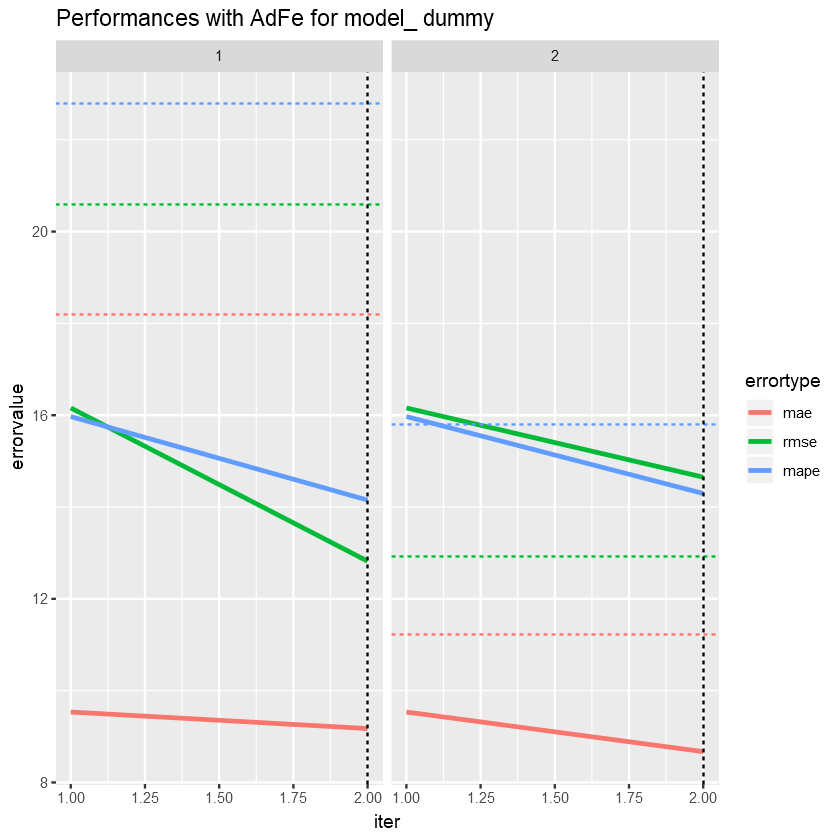

In [80]:
performance_molten_AdFe <- melt(data = performance_table_AdFe
                             , id.vars = c('iter',"seed"))
setnames(performance_molten_AdFe, c("variable","value"),c("errortype","errorvalue"))
p_AdFe = ggplot(performance_molten_AdFe, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1) +
            geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
            facet_wrap(~ seed) +
            geom_vline(xintercept = iteration_history[IsFeatureEliminated==1]$iter_no + 1, linetype = "dashed") +
            #geom_vline(xintercept = iteration_history[IsDataSelected==1]$iter_no + 1, linetype = "dotdash",color = "yellow") +
            ggtitle(paste0("Performances with AdFe for model_ ", model.type))
p_AdFe
ggsave(paste0(outputs.path,"performance_table_AdFe_", model.type,".png"))

## Final Visualization

Saving 6.67 x 6.67 in image


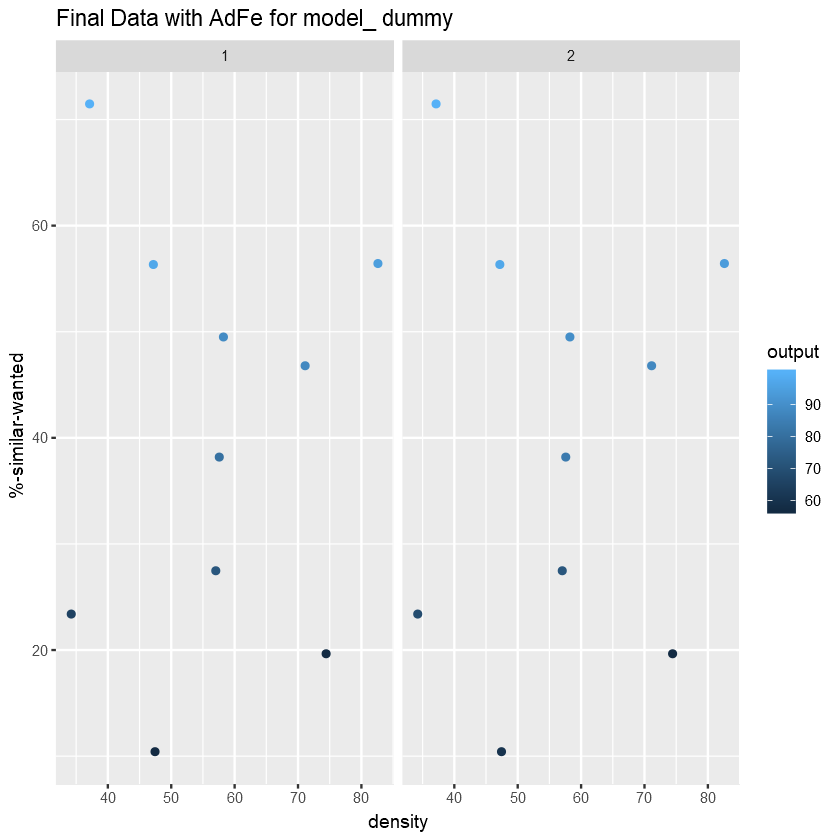

In [81]:
final_AdFe_plot = ggplot(data = FinalTrainData_AdFe, aes(x = density, y = `%-similar-wanted`)) +
                     geom_point(aes(colour = output)) +
                     facet_wrap(~ seed) +
                     labs(legend = "output") +
                     ggtitle(paste0("Final Data with AdFe for model_ ", model.type))
final_AdFe_plot
ggsave(paste0(outputs.path,"FinalTrainData_AdFe_", model.type,".png"))
#pca_final_AdFe_training_set <- princomp(FinalTrainData_AdFe[,.SD, .SDcols = !c("output","seed")], cor = TRUE, scores = TRUE)
#
#pca_final_AdFe_training_set_components <- get_pca_ind(pca_final_AdFe_training_set)
#pca_final_AdFe_training_set_components <-cbind(pca_final_AdFe_training_set_components$coord[,1:2],FinalTrainData_AdFe[,.SD, .SDcols = c("output","seed")])
#p_final_AdFe_training_set <- ggplot(data = pca_final_AdFe_training_set_components, aes(x = Dim.1, y = Dim.2)) +
#             geom_point(aes(colour = output)) +
#             facet_wrap(~ seed) +
#             labs(legend = "output") +
#             ggtitle(paste0("Final Data with AdFe for model_ ", model.type)) 
#p_final_AdFe_training_set
#ggsave(paste0(outputs.path,"FinalTrainData_AdFe_", model.type,".png"))

# Adaptive Sampling with/without Feature Elimination

png 
  2

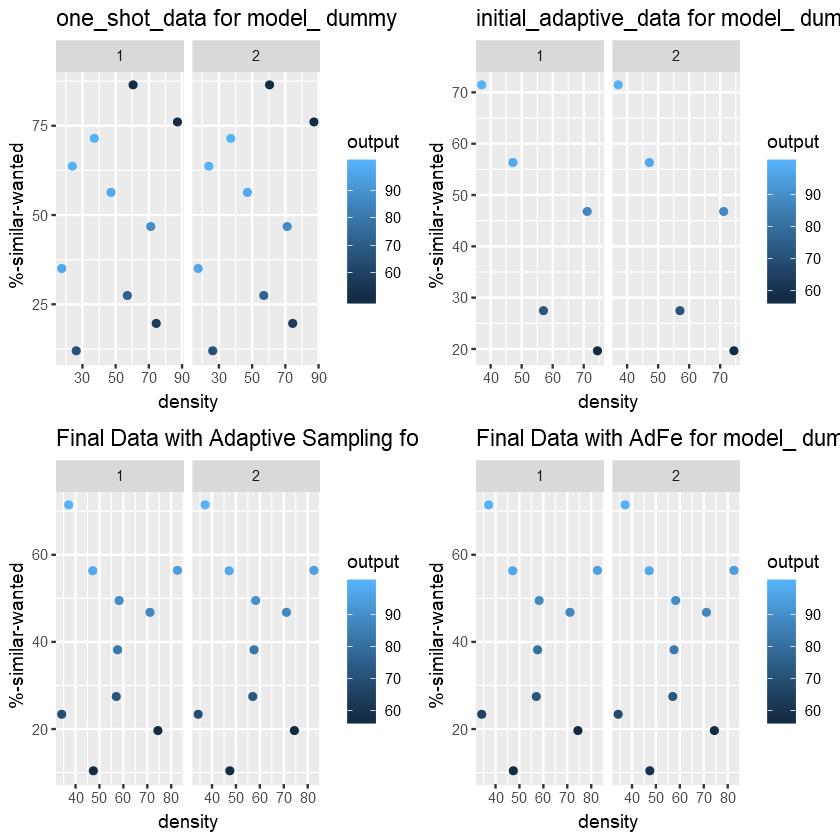

In [82]:
png(paste0(outputs.path,"TrainData_Ad&AdFe_Before_After_", model.type,".png"))
grid.arrange(one_shot_plot, adaptive_initial_plot,final_Ad_plot,final_AdFe_plot,nrow=2, ncol=2)
dev.off()
grid.arrange(one_shot_plot, adaptive_initial_plot,final_Ad_plot,final_AdFe_plot,nrow=2, ncol=2)

Saving 6.67 x 6.67 in image


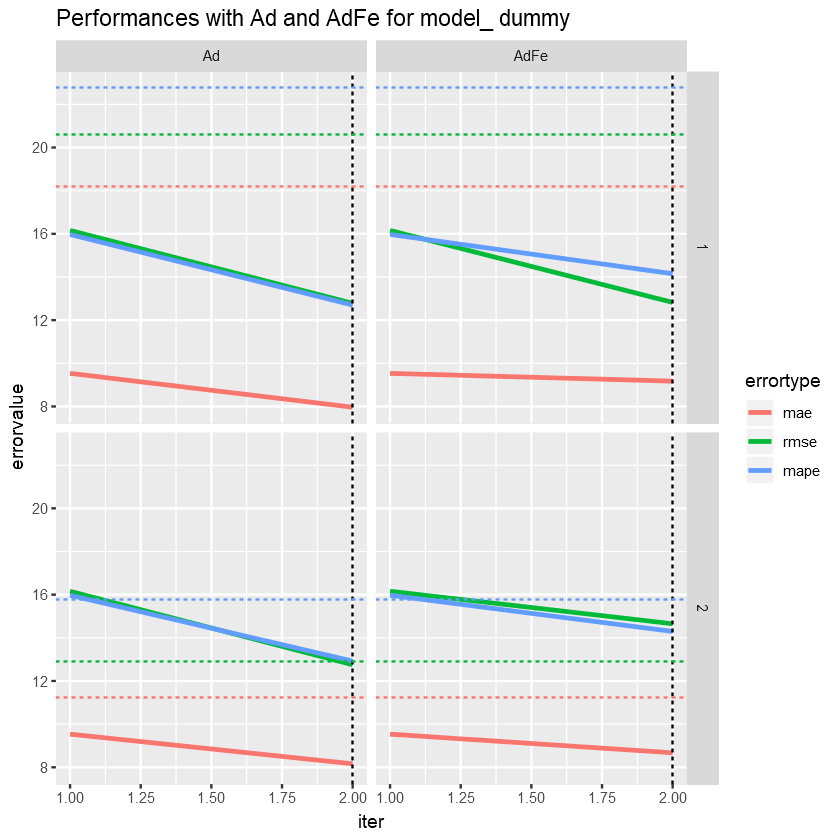

In [83]:
performance_Ad_vs_AdFe = rbind(performance_molten_Ad[,.(iter,seed,errortype,errorvalue, type = "Ad")], performance_molten_AdFe[,.(iter,seed,errortype,errorvalue, type = "AdFe")])
p_Ad_vs_AdFe = ggplot(performance_Ad_vs_AdFe, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1) +
            geom_vline(xintercept = iteration_history[IsFeatureEliminated==1]$iter_no + 1, linetype = "dashed") +
            geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
            facet_grid( seed ~ type)  +
            ggtitle(paste0("Performances with Ad and AdFe for model_ ", model.type))
p_Ad_vs_AdFe
ggsave(paste0(outputs.path,"performance_table_Ad&AdFe_", model.type,".png"))

In [ ]:
ggplotly(p_Ad_vs_AdFe)

Saving 6.67 x 6.67 in image


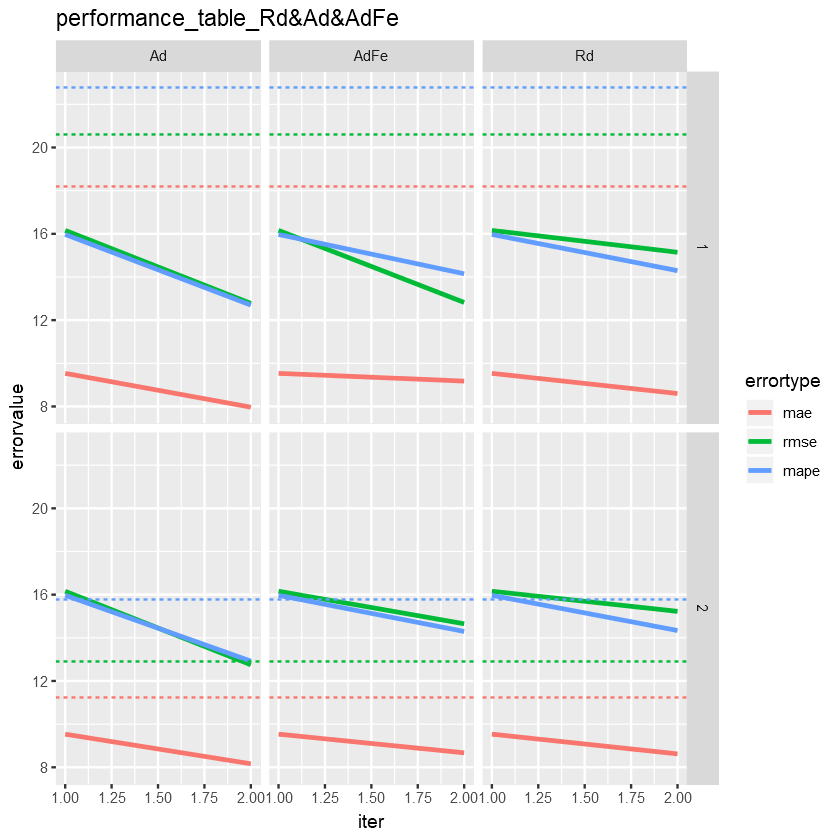

In [84]:
performance_Rd_vs_Ad_vs_AdFe = rbind(performance_Rd_vs_Ad,performance_molten_AdFe[,.(iter,seed,errortype,errorvalue, type = "AdFe")])


p_Rd_vs_Ad_vs_AdFe = ggplot(performance_Rd_vs_Ad_vs_AdFe, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1) +
            geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
            facet_grid( seed ~ type ) +
            ggtitle("performance_table_Rd&Ad&AdFe")
p_Rd_vs_Ad_vs_AdFe
ggsave(paste0(outputs.path,"performance_table_Rd&Ad&Fe_", model.type,".png"))

# Alternative Test Sets

## Different Seeds

In [ ]:
#seed.alt.test = c(1)
#
#performance_compare_seed = copy(performance_Ad_vs_AdFe)
#
#for(s in seed.alt.test){
#    test_set.name = paste0(data.path,"test_set","_",model.type,"_",test_ins,"_seed",s,".csv")
#    test_set <- fread(test_set.name) 
#    assign(paste0("test_set.",s),copy(test_set))
#    
#    pca_test_set_components <- princomp(test_set, cor = TRUE, scores = TRUE) %>% get_pca_ind()
#    p_test_set <- ggplot(data = data.table(pca_test_set_components$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
#                    geom_point() +
#                    ggtitle(paste0("test data for model_ ", model.type)) 
#    assign(paste0("p_test_set.",s),copy(p_test_set))
#    
## Record model performances
#performance_table = data.table(iter = numeric(),seed = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())
#predictedLabels_all = data.table()  
#    
#for( i in seed.Ad){
#    
#    # keep test set undistorted
#    predictedLabels_table = copy(test_set)
#    iter = 1
#    while (iter <= iteration_budget) {
#    
#    model_Sub = copy(get(paste0("model_AdFe_",iter,"_seed_",i)))
#    
#     # Test the model on test set
#    test_predictions_Sub = get_test_predictions(model_Sub, test_set, error_type)
#    predictedLabels_Sub = test_predictions_Sub[[1]]
#    setnames(predictedLabels_Sub, c("pred_output", error_type), c(paste0("pred_output_", iter), paste0(error_type, "_", iter)))
#    predictedLabels_table = cbind(predictedLabels_table, predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_", iter), paste0(error_type, "_", iter))])
#    
#    # Keep test set error records
#    performance_table = rbind(performance_table, data.table(iter,i ,test_predictions_Sub[[2]]), use.names = FALSE)
#    iter = iter + 1  
#    }
#    predictedLabels_all = rbind(predictedLabels_all,data.table(predictedLabels_table,"seed" = i))
#
#}
#
#    assign(paste0("performance_table_AdFe.",s),copy(performance_table))
#    assign(paste0("predictedLabels_table_AdFe.",s),copy(predictedLabels_all))
#    #fwrite(predictedLabels_table_AdFe,paste0(outputs.path,model.type,"_","predictedLabels_table_AdFe",".csv") )
#    #fwrite(performance_table_AdFe,paste0(outputs.path,model.type,"_","performance_table_AdFe",".csv") )
#    
#    performance_molten <- melt(data = performance_table, id.vars = c('iter',"seed"))
#    setnames(performance_molten, c("variable","value"),c("errortype","errorvalue"))
#    assign(paste0("performance_molten_AdFe.",s),copy(performance_molten))
#    
#    performance_compare_seed = rbind(performance_compare_seed
#                               ,performance_molten[,.(iter,seed,errortype,errorvalue, type = paste0("AdFe.",s))])
# }
#
#

In [ ]:
#p_performance_compare_seed = ggplot(performance_compare_seed, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
#            geom_line(lwd=1) +
#            geom_vline(xintercept = iteration_history[IsFeatureEliminated==1]$iter_no + 1, linetype = "dashed") +
#          #  geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
#            facet_grid( seed ~ type)  +
#            ggtitle(paste0("Performances with Ad and AdFe for model_ ", model.type))
#p_performance_compare_seed

## Different Size

In [ ]:
##seed.alt.test = c(1)
#test_ins_alt= c(150,200,300)
#
#performance_compare_size = copy(performance_Ad_vs_AdFe)
#
#for(n in test_ins_alt){
#    test_set.name = paste0(data.path,"test_set","_",model.type,"_",n,".csv")
#    test_set <- fread(test_set.name) 
#    assign(paste0("test_set.size.",n),copy(test_set))
#    
#    pca_test_set_components <- princomp(test_set, cor = TRUE, scores = TRUE) %>% get_pca_ind()
#    p_test_set <- ggplot(data = data.table(pca_test_set_components$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
#                    geom_point() +
#                    ggtitle(paste0("test data for model_ ", model.type)) 
#    assign(paste0("p_test_set.size.",n),copy(p_test_set))
#    
## Record model performances
#performance_table = data.table(iter = numeric(),seed = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())
#predictedLabels_all = data.table()  
#    
#for( i in seed.Ad){
#    
#    # keep test set undistorted
#    predictedLabels_table = copy(test_set)
#    iter = 1
#    while (iter <= iteration_budget) {
#    
#    model_Sub = copy(get(paste0("model_AdFe_",iter,"_seed_",i)))
#    
#     # Test the model on test set
#    test_predictions_Sub = get_test_predictions(model_Sub, test_set, error_type)
#    predictedLabels_Sub = test_predictions_Sub[[1]]
#    setnames(predictedLabels_Sub, c("pred_output", error_type), c(paste0("pred_output_", iter), paste0(error_type, "_", iter)))
#    predictedLabels_table = cbind(predictedLabels_table, predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_", iter), paste0(error_type, "_", iter))])
#    
#    # Keep test set error records
#    performance_table = rbind(performance_table, data.table(iter,i ,test_predictions_Sub[[2]]), use.names = FALSE)
#    iter = iter + 1  
#    }
#    predictedLabels_all = rbind(predictedLabels_all,data.table(predictedLabels_table,"seed" = i))
#
#}
#
#    assign(paste0("performance_table_AdFe.size.",n),copy(performance_table))
#    assign(paste0("predictedLabels_table_AdFe.size.",n),copy(predictedLabels_all))
#    #fwrite(predictedLabels_table_AdFe,paste0(outputs.path,model.type,"_","predictedLabels_table_AdFe",".csv") )
#    #fwrite(performance_table_AdFe,paste0(outputs.path,model.type,"_","performance_table_AdFe",".csv") )
#    
#    performance_molten <- melt(data = performance_table, id.vars = c('iter',"seed"))
#    setnames(performance_molten, c("variable","value"),c("errortype","errorvalue"))
#    assign(paste0("performance_molten_AdFe.size.",n),copy(performance_molten))
#    
#    performance_compare_size = rbind(performance_compare_size
#                               ,performance_molten[,.(iter,seed,errortype,errorvalue, type = paste0("AdFe.size.",n))])
# }
#
#

In [ ]:
#p_performance_compare_size = ggplot(performance_compare_size, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
#            geom_line(lwd=1) +
#            geom_vline(xintercept = iteration_history[IsFeatureEliminated==1]$iter_no + 1, linetype = "dashed") +
#          #  geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
#            facet_grid( seed ~ type)  +
#            ggtitle(paste0("Performances with Ad and AdFe for model_ ", model.type))
#p_performance_compare_size

In [ ]:
#head(train_candidates_table_AdFe)
#head(train_candidates_table_Ad)

In [ ]:
#varImpPlot(model_Ad)

# Quit NL

In [ ]:
NLQuit(nl.obj = nl.model)
#NLQuit(all=FALSE)